In [1]:
import numpy as np
import scipy
import thewalrus.quantum as walq
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.special as scp
import qutip as q
import time
from jupyterthemes import jtplot
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatter
from matplotlib import ticker
from scipy.signal import argrelextrema
import pandas as pd
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#print(plt.rcParams)
plt.rcParams['font.size'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (48,27)
plt.rcParams['legend.fontsize'] = 100
plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['mathtext.rm'] =  'Times New Roman'
# plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
# plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'
# plt.rcParams['mathtext.cal'] = 'cursive'
plt.rcParams['axes.linewidth'] = 5
plt.style.use('seaborn-dark-palette')
tol = 1e-9

In [2]:
color1 = "#1d446c"
color2 = "#f1f1f1"
color3 = "#571a1a"
color4 = "#000000"
color5 = "#525252"
color6 = "#ec2323"

In [3]:
k_tmsv = lambda nb, nav, eta: 1 - (eta**2)*nav*(1+nb)/(1 + nb + np.sqrt(nb*nav*((1+nb)/(1+nav))))**2
vac_mu = np.array([0., 0.])
vac_cov = np.array([[np.exp(0), 0.],[0., np.exp(0)]])

da_best = np.load("data/da_best_V.npy")

In [4]:
class gauss_vqi:
    #This is 2 mode gaussian states
    
    def __init__(self, U_layers, V_layers, Nb, eta, n_p, 
                 idler_factors = (0.5,2,), modes=2, parity = True, load = False):
        self.Nb = Nb
        self.n_p = n_p
        self.idler_factors = idler_factors
        self.eta = eta
        self.U_layers = U_layers
        self.V_layers = V_layers
        if modes == 2:
            self.U_theta = np.zeros(U_layers*6)
        if modes == 1:
            self.U_theta = np.zeros(U_layers*10)
        self.V_theta = np.zeros(4 + V_layers*14)
        if load == True:
            self.V_theta = da_best
        self.modes = modes
        self.parity = parity
        self.load = load
    
    def act_U(self):
        f = len(self.U_theta)//self.U_layers
        prog = sf.Program(2)
        with prog.context as qq:
            Vac | qq[0]
            Vac | qq[1]
            for i in range(self.U_layers):
                a1 = self.U_theta[f*i] + 1j*self.U_theta[f*i+1]
                a2 = self.U_theta[f*i+2] + 1j*self.U_theta[f*i+3]
                Dgate(np.abs(a1),np.angle(a1)) | qq[0]
                Dgate(np.abs(a2),np.angle(a2)) | qq[1]
                if self.modes == 2:
                    z3 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    S2gate(np.abs(z3),np.angle(z3)) | (qq[0],qq[1])
                else:
                    z1 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    z2 = self.U_theta[f*i+6] + 1j*self.U_theta[f*i+7]
                    e1 = self.U_theta[f*i+8]
                    e2 = self.U_theta[f*i+9]
                    BSgate(e1) | (qq[0],qq[1])
                    Sgate(np.abs(z1),np.angle(z1)) | qq[0]
                    Sgate(np.abs(z2),np.angle(z2)) | qq[1]
                    BSgate(e2) | (qq[0],qq[1])
        eng = sf.Engine('gaussian')
        state = eng.run(prog).state
        return state
            
    def _map(self, eta = None, trace = False):
        #print(self.U_theta)
        f = len(self.U_theta)//self.U_layers
        if eta == None:
            eta = self.eta
        prog = sf.Program(3)
        with prog.context as qq:
            Vac | qq[2] #Signal
            Vac | qq[1] #Idler
            Thermal(self.Nb) | qq[0] #Background
            for i in range(self.U_layers):
                a1 = self.U_theta[f*i] + 1j*self.U_theta[f*i+1]
                a2 = self.U_theta[f*i+2] + 1j*self.U_theta[f*i+3]
                Dgate(np.abs(a1),np.angle(a1)) | qq[2]
                Dgate(np.abs(a2),np.angle(a2)) | qq[1]
                if self.modes == 2:
                    z3 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    S2gate(np.abs(z3),np.angle(z3)) | (qq[2],qq[1])
                else:
                    z1 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    z2 = self.U_theta[f*i+6] + 1j*self.U_theta[f*i+7]
                    e1 = self.U_theta[f*i+8]
                    e2 = self.U_theta[f*i+9]
                    BSgate(e1) | (qq[2],qq[1])
                    Sgate(np.abs(z1),np.angle(z1)) | qq[2]
                    Sgate(np.abs(z2),np.angle(z2)) | qq[1]
                    BSgate(e2) | (qq[2],qq[1])
            BSgate(eta) | (qq[0],qq[2])
            Del | qq[2]
        eng = sf.Engine('gaussian')
        new_state = eng.run(prog).state
        if trace:
            return q.Qobj(new_state.dm().transpose(np.arange(2*2).reshape([2,2]).T.flatten()).reshape([10**2, 10**2]))
        return new_state#.reduced_gaussian([0,2])

    
    def full_circuit(self,eta):
        prog = sf.Program(4)
        with prog.context as qq:
            Vac | qq[0]
            Thermal(self.Nb) | qq[1] #Background
            Vac | qq[3] #Signal
            Vac | qq[2] #Idler
            f = len(self.U_theta)//self.U_layers
            for i in range(self.U_layers):
                a1 = self.U_theta[f*i] + 1j*self.U_theta[f*i+1]
                a2 = self.U_theta[f*i+2] + 1j*self.U_theta[f*i+3]
                Dgate(np.abs(a1),np.angle(a1)) | qq[3]
                Dgate(np.abs(a2),np.angle(a2)) | qq[2]
                if self.modes == 2:
                    z3 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    S2gate(np.abs(z3),np.angle(z3)) | (qq[3],qq[2])
                else:
                    z1 = self.U_theta[f*i+4] + 1j*self.U_theta[f*i+5]
                    z2 = self.U_theta[f*i+6] + 1j*self.U_theta[f*i+7]
                    e1 = self.U_theta[f*i+8]
                    e2 = self.U_theta[f*i+9]
                    BSgate(e1) | (qq[3],qq[2])
                    Sgate(np.abs(z1),np.angle(z1)) | qq[3]
                    Sgate(np.abs(z2),np.angle(z2)) | qq[2]
                    BSgate(e2) | (qq[3],qq[2])
            f = (len(self.V_theta)-4)//self.V_layers
            BSgate(eta) | (qq[1],qq[3])
            Del | qq[3]
            for i in range(self.V_layers):
                for j in [0,1,2]:
                    a = self.V_theta[f*i+2*j+0] + self.V_theta[f*i+2*j+1]*1j
                    #z = 0*self.V_theta[f*i+4*j+2] + 0*self.V_theta[f*i+4*j+3]*1j
                    Dgate(np.abs(a),np.angle(a)) | qq[j]
                    #Sgate(np.abs(z),np.angle(z)) | qq[j]
                cx1 = self.V_theta[f*i+12]
                cx2 = self.V_theta[f*i+13]
                bs0_th = self.V_theta[f*i+6]
                bs0_ph = self.V_theta[f*i+7]
                bs1_th = self.V_theta[f*i+8] 
                bs2_th = self.V_theta[f*i+9] 
                bs1_ph = self.V_theta[f*i+10] 
                bs2_ph = self.V_theta[f*i+11]
                #CZgate(cz1) | (qq[0],qq[1])
                #CZgate(cz2) | (qq[1],qq[2])
                CXgate(cx1) | (qq[0],qq[1])
                CXgate(cx2) | (qq[1],qq[2])
                BSgate(bs0_th,bs0_ph) | (qq[1],qq[2])
                BSgate(bs1_th,bs1_ph) | (qq[0],qq[1])
                BSgate(bs2_th,bs2_ph) | (qq[0],qq[2])
            a = self.V_theta[-3] + self.V_theta[-2]*1j
            z = self.V_theta[-1] + self.V_theta[-4]*1j
            Sgate(np.abs(z),np.angle(z)) | qq[0]
            Dgate(np.abs(a),np.angle(a)) | qq[0]
            Del | qq[1]
            Del | qq[2]
        eng = sf.Engine('gaussian')
        state = eng.run(prog).state
        a = np.linalg.det(state.cov())
        if a < 0:
            print("Flag")
            print(self.V_theta)
            print(state.mean_photon(0))
        p = np.real(state.fidelity_vacuum())#np.real(state.fidelity((vac_mu,vac_cov),0))
        if self.parity:
            p = state.parity_expectation([0])#state.wigner(0,0,0)*2*np.pi#
        return p, state#fidelity_vac(state), state##
    
    def trace_distance(self):
        rho0 = self._map(0,trace=True)
        rho1 = self._map(trace=True)
        return (rho1/rho1.norm()-rho0/rho0.norm()).norm()
    
    def _cost_trace(self, x):
        self.V_theta = x
        p0, state0 = self.full_circuit(0)
        p1, state1 = self.full_circuit(self.eta)
        est = p1 - p0
        if state0.mean_photon(0)[1] >= 1000:
            return max(100,np.abs((state0.mean_photon(0)[1] - 1000)))*(state0.mean_photon(0)[1] - 1000)
        a = min(np.linalg.det(state0.cov()),np.linalg.det(state1.cov()))
        if a <= 1:
            return max(100,-a)
        if max(p0,p1) >= 1:
            return 100
        return -abs(est)
    
    def _cost_full(self):
        self.U_theta = x[0:len(self.U_theta)]
        self.V_theta = x[len(self.U_theta):]
        p0, state0 = self.full_circuit(0)
        p1, state1 = self.full_circuit(self.eta)
        est = p1 - p0
        if state0.mean_photon(0)[1] >= 1000:
            return max(100,np.abs((state0.mean_photon(0)[1] - 1000)))*(state0.mean_photon(0)[1] - 1000)
        a = np.linalg.det(state0.cov())
        a = min(np.linalg.det(state0.cov()),np.linalg.det(state1.cov()))
        if a <= 1:
            return max(100,-a)
        if max(p0,p1) >= 1:
            return 100
        #print(p1,p0)
        return -abs(est)
    
    
    def temp_trace(self):
        x0 = np.random.random(len(self.V_theta))
        if self.load:
            x0 = self.V_theta
        #x0[1] = np.sqrt(self.n_p/2)*(1-0.2*np.random.random())
        #x0[3] = np.sqrt(self.n_p/2)*(1-0.2*np.random.random())
        opti = scipy.optimize.minimize(self._cost_trace,x0=x0,method="Powell")
        self.V_theta = opti.x
        print(-2*opti.fun, self.trace_distance())
        
    def trace_estimate(self,x=None):
        return -2*self._cost_trace(x)
        
    def _cost(self, x):
        self.U_theta = x
        return -self.trace_distance()
    
    def _con_np_only(self, x):
        self.U_theta = x[0:len(self.U_theta)]
        n_av,_ = (self.act_U()).mean_photon(0)
        #print(n_av)
        return -abs(n_av - self.n_p)
    
    def _con_n_idler(self, x):
        self.U_theta = x[0:len(self.U_theta)]
        n_av,_ = (self.act_U()).mean_photon(1)
        #print(n_av)
        return -(n_av - self.idler_factors[0]*self.n_p)*(n_av - self.idler_factors[1]*self.n_p)

    def optimize(self):
        x0 = np.random.random(len(self.U_theta))
        opti = scipy.optimize.minimize(self._cost,x0=x0, constraints = [{'type':'ineq', 'fun': self._con_np_only},
                                                                        {'type':'ineq', 'fun': self._con_n_idler}], method = 'COBYLA')
        self.U_theta = opti.x
    
    def optimize_full(self):
        x0 = np.array(list(np.zeros(len(self.U_theta))) + list(np.random.random(len(self.V_theta))))
        if self.load:
            x0 = np.array(list(np.zeros(len(self.U_theta))) + list(self.V_theta))
        opti = scipy.optimize.minimize(self._cost_full,x0=x0, constraints = [{'type':'ineq', 'fun': self._con_np_only},
                                                                        {'type':'ineq', 'fun': self._con_n_idler}], method='trust-constr')
        self.U_theta = opti.x[:len(self.U_theta)]
        self.V_theta = opti.x[len(self.U_theta):]
        print(-2*opti.fun)
    
    def QFI(self,delta=1e-5):
        state = self.act_U()
        rho0 = self._map(0,trace=True)
        rho_eta = self._map(delta,trace=True)
        rho0 = rho0/rho0.norm()
        rho_eta = rho_eta/rho_eta.norm()
        drho_eta = (rho_eta - rho0)/delta
        L = 2*scipy.linalg.solve_continuous_lyapunov(rho0,drho_eta)
        return np.real(np.trace(L@L@rho0.full()))
    
    def QFI1(self,delta=1e-5):
        state = self.act_U()
        rho0 = self._map(0,trace=True)
        rho_eta = self._map(delta,trace=True)
        rho0 = rho0/rho0.norm()
        rho_eta = rho_eta/rho_eta.norm()
        drho_eta = (rho_eta/rho_eta.norm() - rho0/rho0.norm())/delta
        lam, eig = rho0.eigenstates()
        qfi = 0
        for i in range(len(lam)):
            for j in range(len(lam)):
                if lam[i]+lam[j] > tol:
                    qfi += 2*(abs(drho_eta.matrix_element(eig[i].dag(),eig[j]))**2)/(lam[i]+lam[j]+tol)
        return np.real(qfi)
    
    def _opti_fidelityTMSV(self,x):
        z = np.arcsinh(np.sqrt(self.n_p))*np.exp(1j*x)
        a = q.destroy(10)
        U = (z*q.tensor(a,a) - (z*q.tensor(a,a)).dag()).expm()
        TMSV = U*q.tensor(q.fock_dm(10),q.fock_dm(10))*U.dag()
        state = self.act_U().dm()#.transpose(np.arange(2*2).reshape([2,2]).T.flatten()).reshape([10**2, 10**2])
        if state.shape != (100,100):
            state = state.transpose(np.arange(2*2).reshape([2,2]).T.flatten()).reshape([10**2, 10**2])
        return -q.fidelity(TMSV,q.Qobj(state/np.trace(state),dims=[[10,10],[10,10]]))
    
    def fidelityTMSV(self):
        opti = scipy.optimize.minimize_scalar(self._opti_fidelityTMSV)
        return -opti.fun
    
    def _opti_chern(self,s):
        if s >1 or s <0:
            return np.inf
        state = self.act_U()
        rho0 = self._map(0,trace=True)
        rho1 = self._map(trace=True)
        rho0 = rho0/rho0.norm()
        rho1 = rho1/rho1.norm()
        return np.log(abs(np.trace(scipy.linalg.fractional_matrix_power(rho0,s)@scipy.linalg.fractional_matrix_power(rho1,1-s))))
    
    def chernoff(self):
        opti = scipy.optimize.minimize_scalar(self._opti_chern,bounds=(0,1))
        return np.exp(opti.fun)
    
    def bhattacharya(self):
        return -self._opti_chern(0.5)

In [5]:
Vchern0 = []
Vchern1 = []
Vchern2 = []

Vqfi0 = []
Vqfi1 = []
Vqfi2 = []

Vtrace0 = []
Vtrace1 = []
Vtrace2 = []

Vetrace1 = np.load("data/vac_gauss_est_2mode.npy",allow_pickle=True)
Veetrace1 = []
#Vetrace2 = np.load("data/vac_gauss_est_1mode.npy",allow_pickle=True)
Veetrace2 = []

Vfidel1 = []
Vfidel2 = []

Vtheta1 = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)
#Vtheta2 = np.load("data/vac_gauss_th_1mode.npy",allow_pickle=True)

nb = np.linspace(2/40,2,40)

for i in range(len(nb)):
    print("=============================")
    obj1 = gauss_vqi(1,1,nb[i],1e-3,0.1,parity=True,load=True,idler_factors = (1,2,))
    obj1.U_theta, obj1.V_theta = Vtheta1[i]
    Vchern1.append(obj1.chernoff())
    Vtrace1.append(obj1.trace_distance())
    Vqfi1.append(obj1.QFI1())
    Vfidel1.append(obj1.fidelityTMSV())
    Veetrace1.append(-2*obj1._cost_trace(obj1.V_theta))
    print()
    
#     print("==============1==============")
#     obj2 = gauss_vqi(1,1,nb[i],1e-3,0.1,modes=1,parity=True,load=True,idler_factors = (1,5,))
#     obj2.U_theta, obj2.V_theta = theta2[i]
#     chern2.append(obj2.chernoff())
#     trace2.append(obj2.trace_distance())
#     qfi2.append(obj2.QFI1())
#     fidel2.append(obj2.fidelityTMSV())
#     eetrace2.append(-2*obj2._cost_trace(obj2.V_theta))
#     print()
    
    obj0 = gauss_vqi(1,1,nb[i],1e-3,0.1)
    obj0.U_theta[-2] = np.arcsinh(np.sqrt(0.1))
    Vchern0.append(obj0.chernoff())
    Vtrace0.append(obj0.trace_distance())
    Vqfi0.append(obj0.QFI1())

D:\Apps\Anaconda\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars


D:\Apps\Anaconda\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars


In [6]:
obj1 = gauss_vqi(1,1,1,1e-3,0.1,parity=True,load=True,idler_factors = (1,2,))
obj1.U_theta, obj1.V_theta = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)[19]

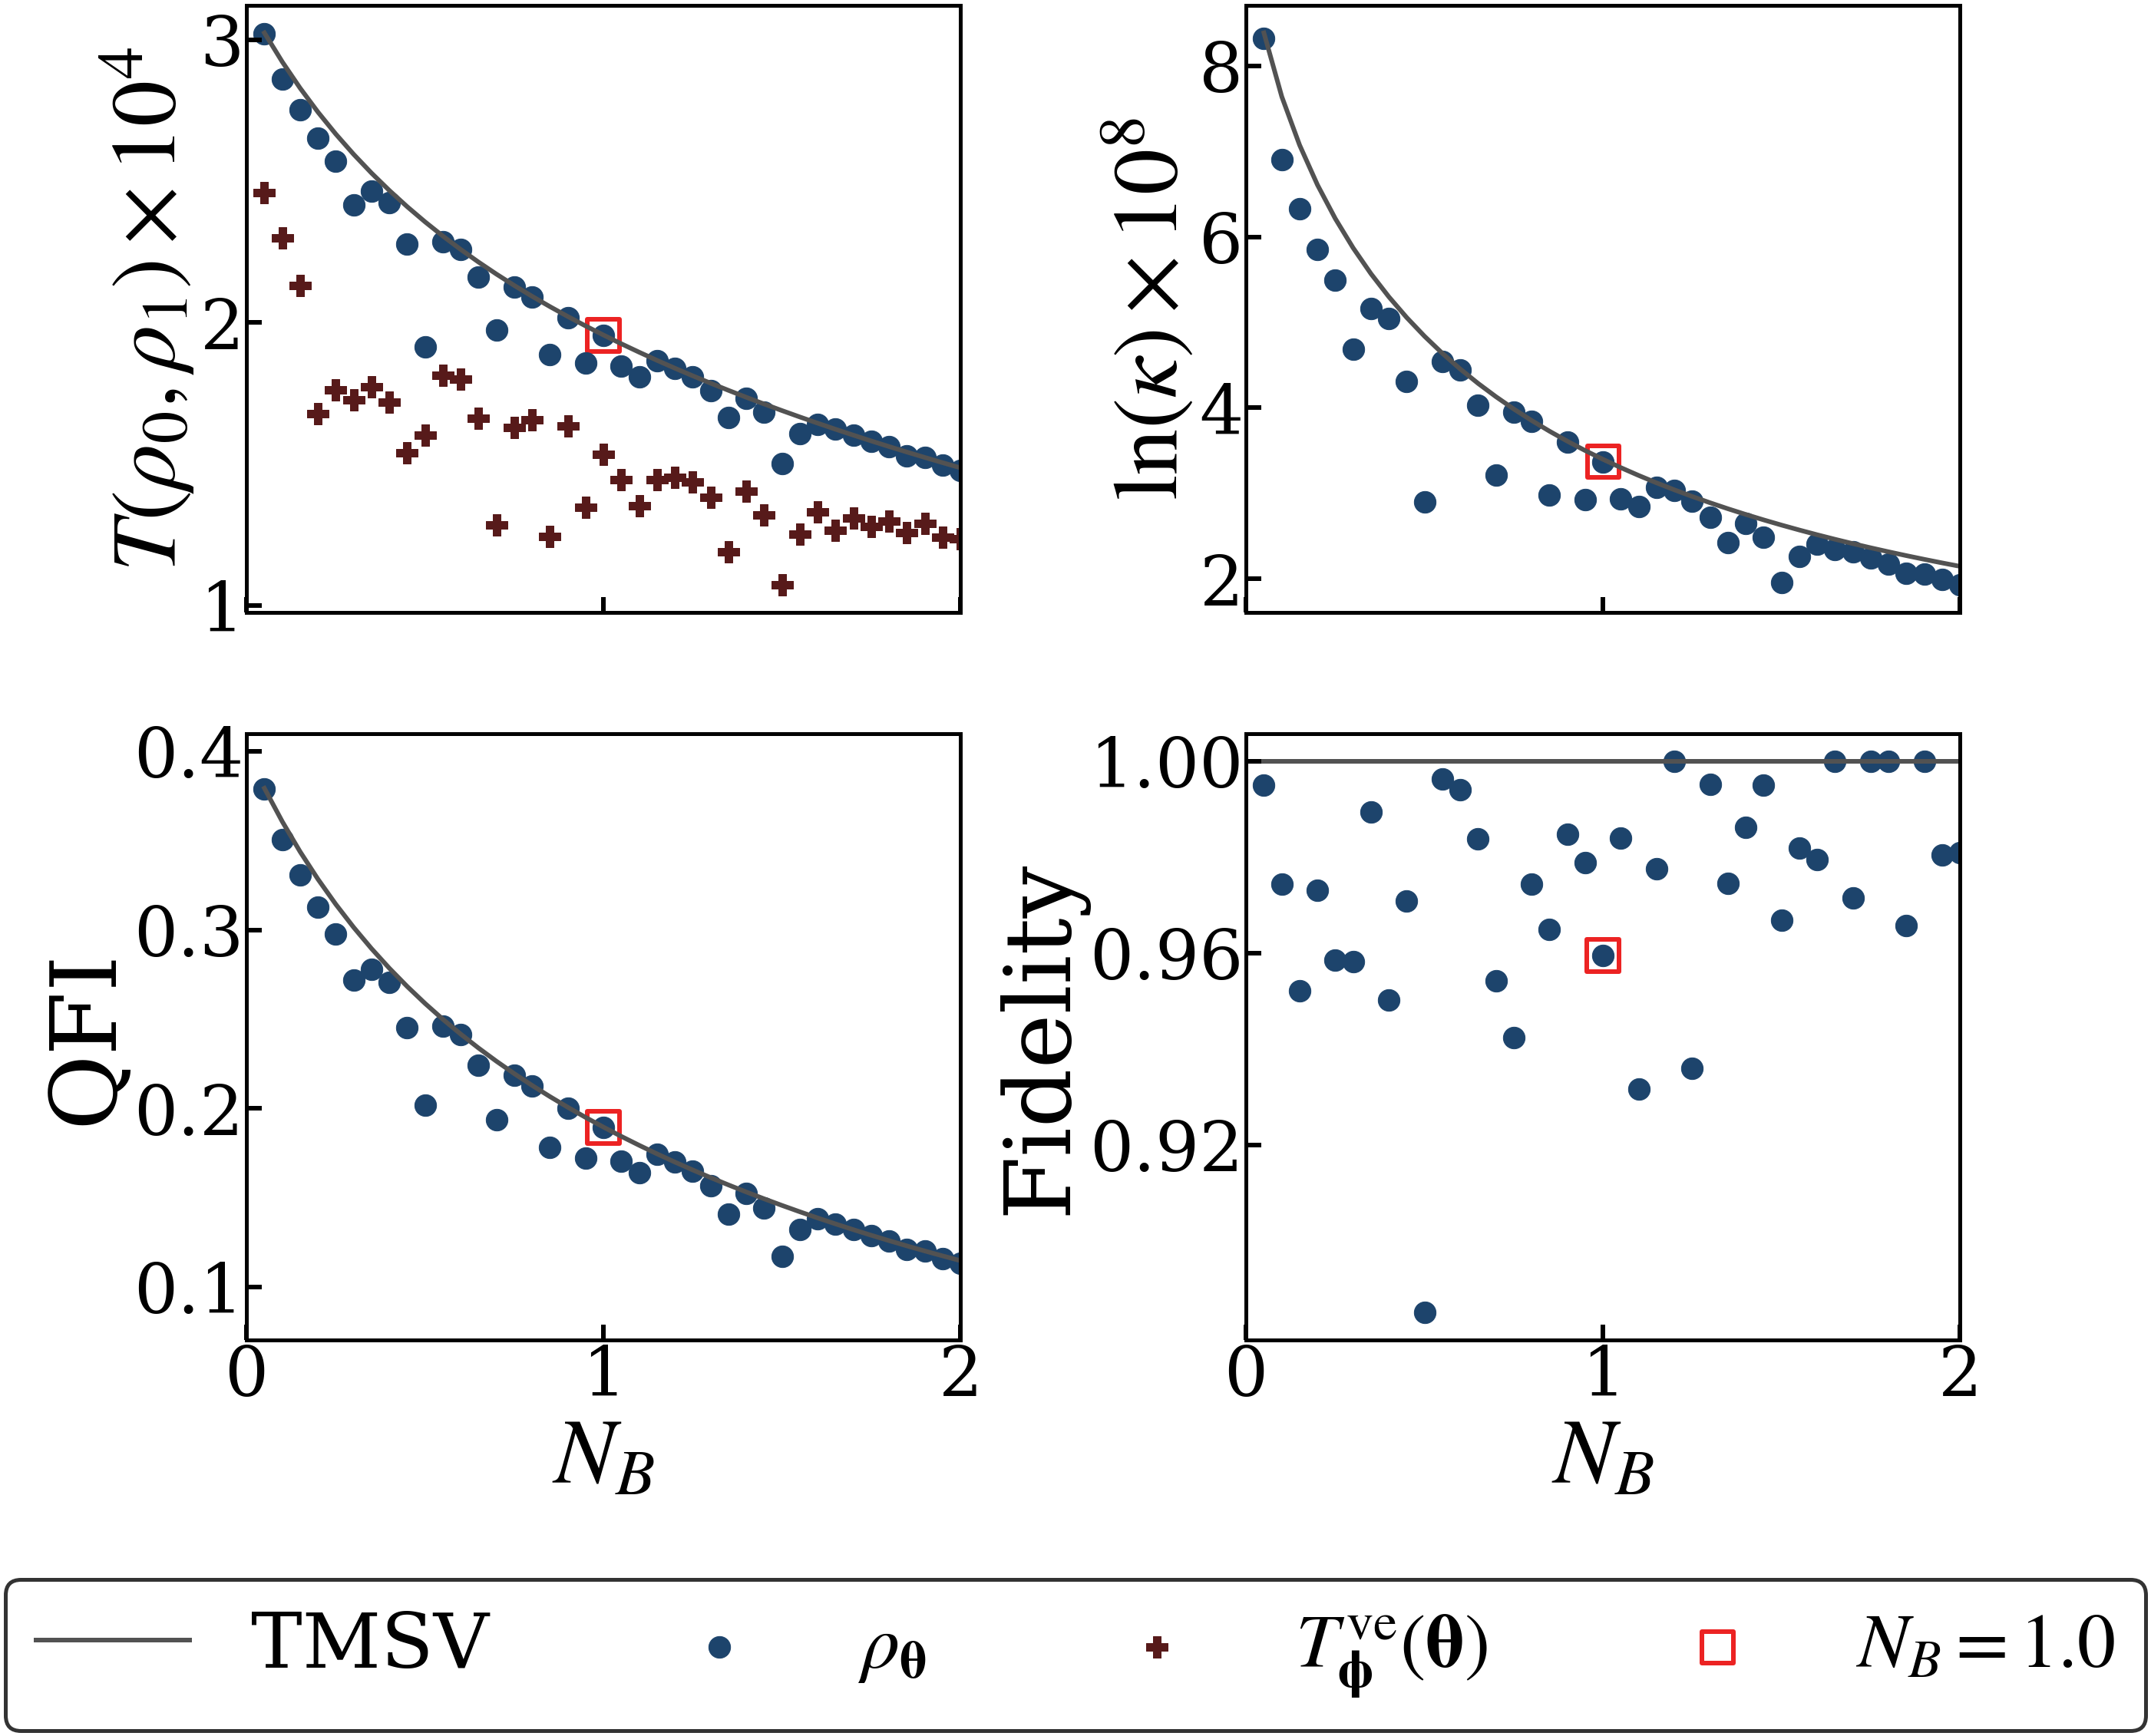

In [7]:
idx = 19
mmm = 's'
ssi = 1700

plt.rcParams['axes.linewidth'] = 5
plt.rcParams["figure.figsize"] = (40,32)
plt.rcParams['font.size'] = 90
rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols, sharex='col')
fig.subplots_adjust(wspace=0.4)
#fig.suptitle("Quantum Fisher Information and classical Fisher information for the setup",fontsize=80)

l1, = ax[0,1].plot(nb,-1*np.log(k_tmsv(nb,0.1,1e-3))*1e8,color=color5,linewidth=6)
l4 = ax[0,1].scatter(nb[idx],-1*np.log(np.real(Vchern1)[idx])*1e8,s=ssi,color=color6,marker=mmm,facecolors='none', linewidth=6,edgecolors=color6)
l2 = ax[0,1].scatter(nb,-1*np.log(np.real(Vchern1))*1e8,color=color1,s=800)
ax[0,1].set_ylabel(r'$\ln(\kappa)\times10^8$',fontsize=120)
ax[0,1].tick_params(direction='in', length=20, width=6)
ax[0,1].set_xlim(0,2)
#ax[0,0].set_yticks([5,9],fontsize=70)



ax[0,0].plot(nb,0.5e4*np.real(Vtrace0),color=color5,linewidth=6)
ax[0,0].scatter(nb[idx],0.5e4*np.real(Vtrace1[idx]),color=color6,s=ssi,marker=mmm)
ax[0,0].scatter(nb[idx],0.5e4*np.real(Vtrace1[idx]),s=ssi,color=color6,marker=mmm,facecolors='white', linewidth=6,edgecolors=color6)
ax[0,0].scatter(nb,0.5e4*np.real(Vtrace1),color=color1,s=800)
l3 = ax[0,0].scatter(nb,0.5e4*np.real(Veetrace1),color=color3,s=800,marker="P")
ax[0,0].set_xlim(0,2)
ax[0,0].set_ylabel(r'$T(\rho_0,\rho_1)\times 10^4$',fontsize=120)
#ax[0,1].yaxis.set_label_position("right")
ax[0,0].tick_params(direction='in', length=20, width=6)
#ax[0,1].grid(True,linestyle='solid',linewidth=4)

ax[1,0].plot(nb,np.real(Vqfi0),color=color5,linewidth=6)
ax[1,0].scatter(nb[idx],np.real(Vqfi1)[idx],color=color6,s=ssi,marker=mmm)
ax[1,0].scatter(nb[idx],np.real(Vqfi1)[idx],s=ssi,color=color6,marker=mmm,facecolors='white', linewidth=6,edgecolors=color6)
ax[1,0].scatter(nb,np.real(Vqfi1),color=color1,s=800)
ax[1,0].set_ylabel(r'QFI',fontsize=120)
ax[1,0].tick_params(direction='in', length=20, width=6)
ax[1,0].set_xlim(0,2)
#ax[1,0].set_xticks([1.1,1.5,1.9],fontsize=70)
ax[1,0].set_ylim(0.07,0.41)
ax[1,0].set_yticks([0.1,0.2,0.3,0.4])#,fontsize=70)
ax[1,0].set_xlabel(r"$N_B$",fontsize=120)

ax[1,1].plot(nb,1+0*nb,color=color5,linewidth=6)
ax[1,1].scatter(nb[idx],Vfidel1[idx],color=color6,s=ssi,marker=mmm)
ax[1,1].scatter(nb[idx],Vfidel1[idx],s=ssi,color=color6,marker=mmm,facecolors='white', linewidth=6,edgecolors=color6)
ax[1,1].scatter(nb,Vfidel1,color=color1,s=800)
ax[1,1].set_ylabel(r'Fidelity',fontsize=120)
#ax[1,1].yaxis.set_label_position("right")
ax[1,1].set_xlim(0,2)
ax[1,1].set_yticks([0.92,0.96,1.0])
ax[1,1].tick_params(direction='in', length=20, width=6)
#ax[1,1].grid(True,linestyle='solid',linewidth=2.5)
ax[1,1].set_xlabel(r"$N_B$",fontsize=120)


lines = [l1,l2,l3,l4]
labels=[r"TMSV",#"QFI for resonant tunneling setup",
        r"$\rho_{\mathbf{\theta}}$",#"Maximal QFI for resonant tunneling setup",
        r"$T^{\mathrm{ve}}_{\mathbf{\phi}}(\mathbf{\theta})$",
        r"$N_B = "+str(round(nb[idx],2))+"$"]#"CFI for single barrier setup"]
legend = fig.legend(lines,     # The line objects
           labels,   # The labels for each line
           loc="lower center",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           bbox_to_anchor=(0.5,-0.1),
           fancybox=True, ncol=4, fontsize=100)
legend.get_frame().set_linewidth(5)
legend.get_frame().set_edgecolor("black")
plt.show()
plt.rcParams['font.size'] = 100
plt.show()

In [9]:
V_NB1 = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)[19]
obj_NB1 = gauss_vqi(1,1,1,1e-3,0.1,parity=False)
obj_NB1.U_theta, obj_NB1.V_theta = V_NB1
state_NB1 = obj_NB1.act_U()
a = q.Qobj(state_NB1.dm().transpose(),dims=[[10,10],[10,10]])
b = (a.ptrace(1)).eigenenergies()
b

array([1.92458590e-10, 3.66475165e-09, 4.41144006e-08, 4.91878070e-07,
       5.45069746e-06, 6.03874183e-05, 6.69019663e-04, 7.41192949e-03,
       8.21152229e-02, 9.09737450e-01])

In [10]:
V_NB1 = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)[19]
obj_NB1 = gauss_vqi(1,1,1,1e-3,0.1,parity=False)
obj_NB1.U_theta[-2] = np.arcsinh(np.sqrt(0.1))
state_NB11 = obj_NB1.act_U()
a1 = q.Qobj(state_NB11.dm().transpose(),dims=[[10,10],[10,10]])
b1 = (a1.ptrace(1)).eigenenergies()
b1

array([3.85543289e-10, 4.24097618e-09, 4.66507380e-08, 5.13158118e-07,
       5.64473930e-06, 6.20921323e-05, 6.83013455e-04, 7.51314801e-03,
       8.26446281e-02, 9.09090909e-01])

In [11]:
-np.real(np.trace(a.ptrace(1).full()@scipy.linalg.logm(a.ptrace(1).full()))), -np.real(np.trace(a1.ptrace(1).full()@scipy.linalg.logm(a1.ptrace(1).full())))

(0.3332223308457541, 0.33509970612111517)

C:\Users\MAHADE~1\AppData\Local\Temp/ipykernel_24128/3340258684.py:9: UserWarning: The following kwargs were not used by contour: 'lw', 'rstride', 'cstride'


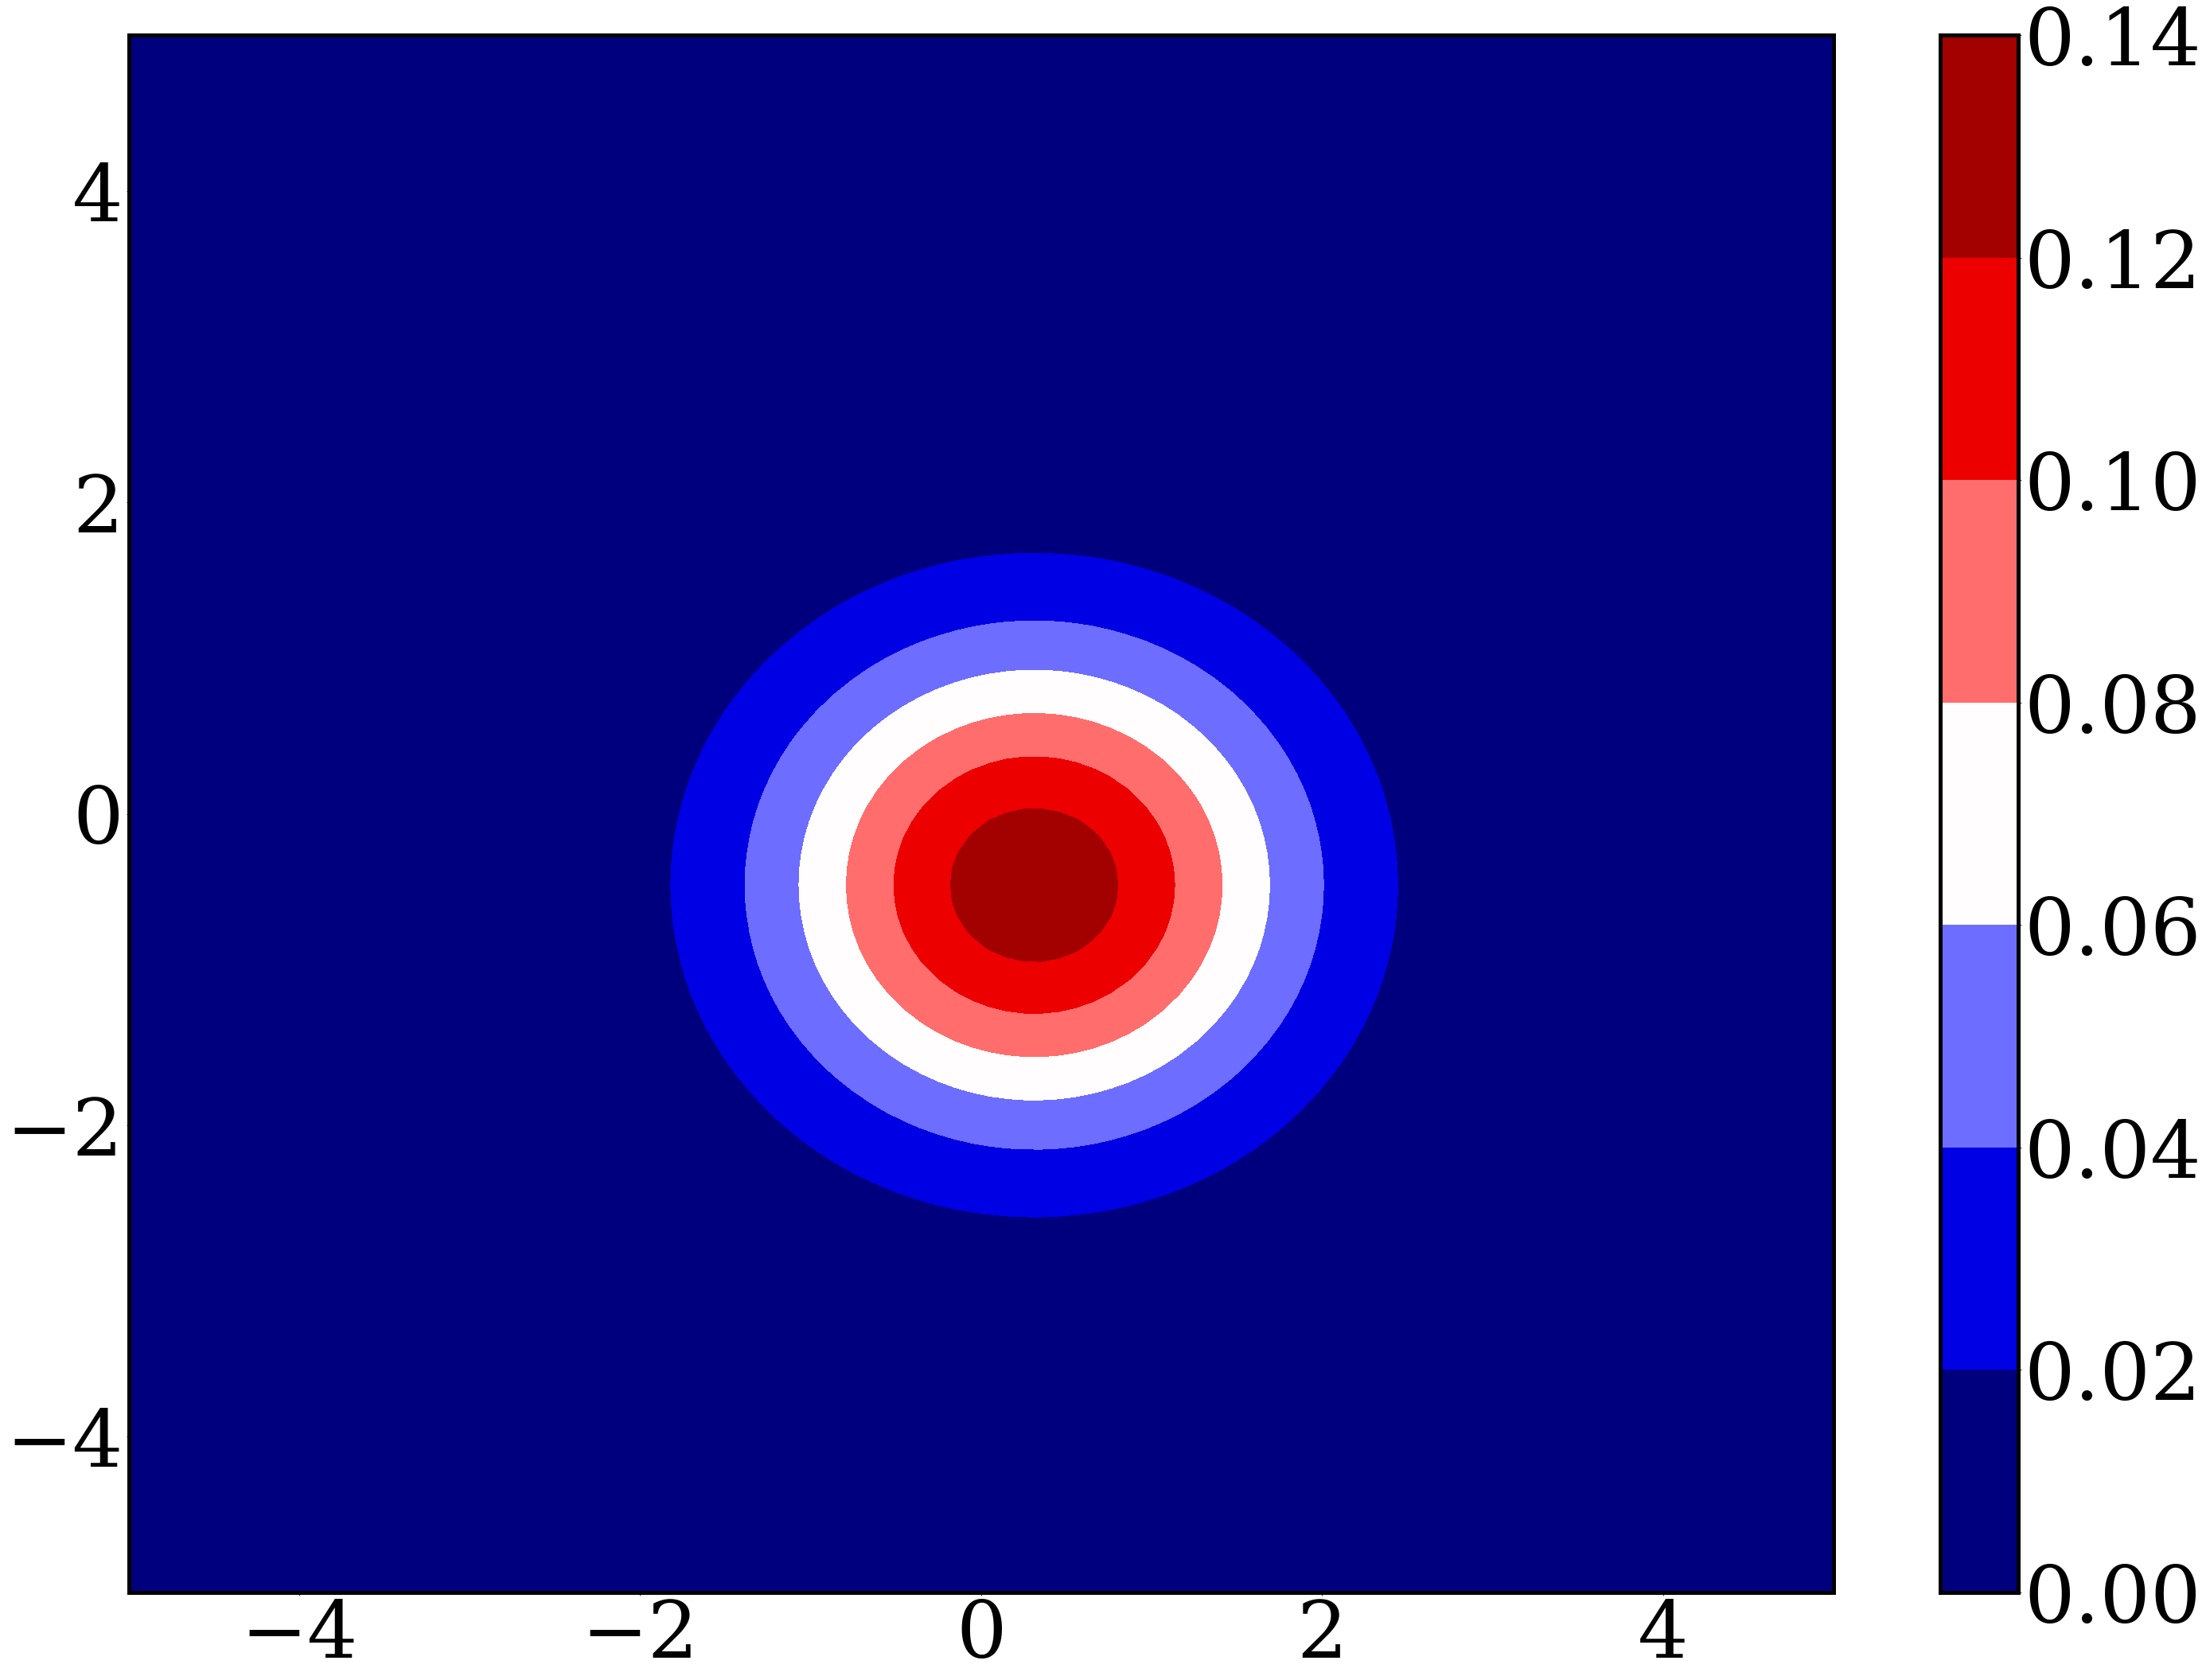

In [12]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (48,36)

X = np.linspace(-5, 5, 100)
P = np.linspace(-5, 5, 100)
Z = state_NB1.wigner(1, X, P)
X, P = np.meshgrid(X, P)
ax = fig.add_subplot(111)
plt.contourf(X, P, Z, cmap="seismic", lw=0.5, rstride=1, cstride=1)
plt.colorbar()

In [13]:
def noise_obj(Nb, Vt):
    obj_noise = gauss_vqi(1,1,Nb,1e-3,0.1,parity=False)
    noise = np.linspace(0.01/50,1e-2,100)
    noise_max = []
    noise_min = []
    noise_avg = []
    noise_std = []
    for i in noise:
        trace_noise = []
        for _ in range(500):
            trace_noise.append(-2*obj_noise._cost_full(np.random.normal(Vt,i*np.absolute(Vt))))
        noise_max.append(max(trace_noise))
        noise_min.append(min(trace_noise))
        noise_avg.append(np.average(trace_noise))
        noise_std.append(np.std(trace_noise))
    return noise_max, noise_min, noise_avg, noise_std

In [14]:
idx = [14,19,24]
# Vtheta = [np.array(list(Vtheta1[i][0]) + list(Vtheta1[i][1])) for i in idx]
NoiseMax = np.load("data/NoiseMax.npy",allow_pickle=True)
NoiseMin = np.load("data/NoiseMin.npy",allow_pickle=True)
NoiseAvg = np.load("data/NoiseAvg.npy",allow_pickle=True)
NoiseStd = np.load("data/NoiseStd.npy",allow_pickle=True)
# for i in range(len(idx)):
#     noise_max, noise_min, noise_avg, noise_std = noise_obj(nb[idx[i]],Vtheta[i])
#     NoiseMax.append(noise_max)
#     NoiseMin.append(noise_min)
#     NoiseAvg.append(noise_avg)
#     NoiseStd.append(noise_std)
# np.save("data/NoiseMax.npy",NoiseMax)
# np.save("data/NoiseAvg.npy",NoiseAvg)
# np.save("data/NoiseMin.npy",NoiseMin)
# np.save("data/NoiseStd.npy",NoiseStd)

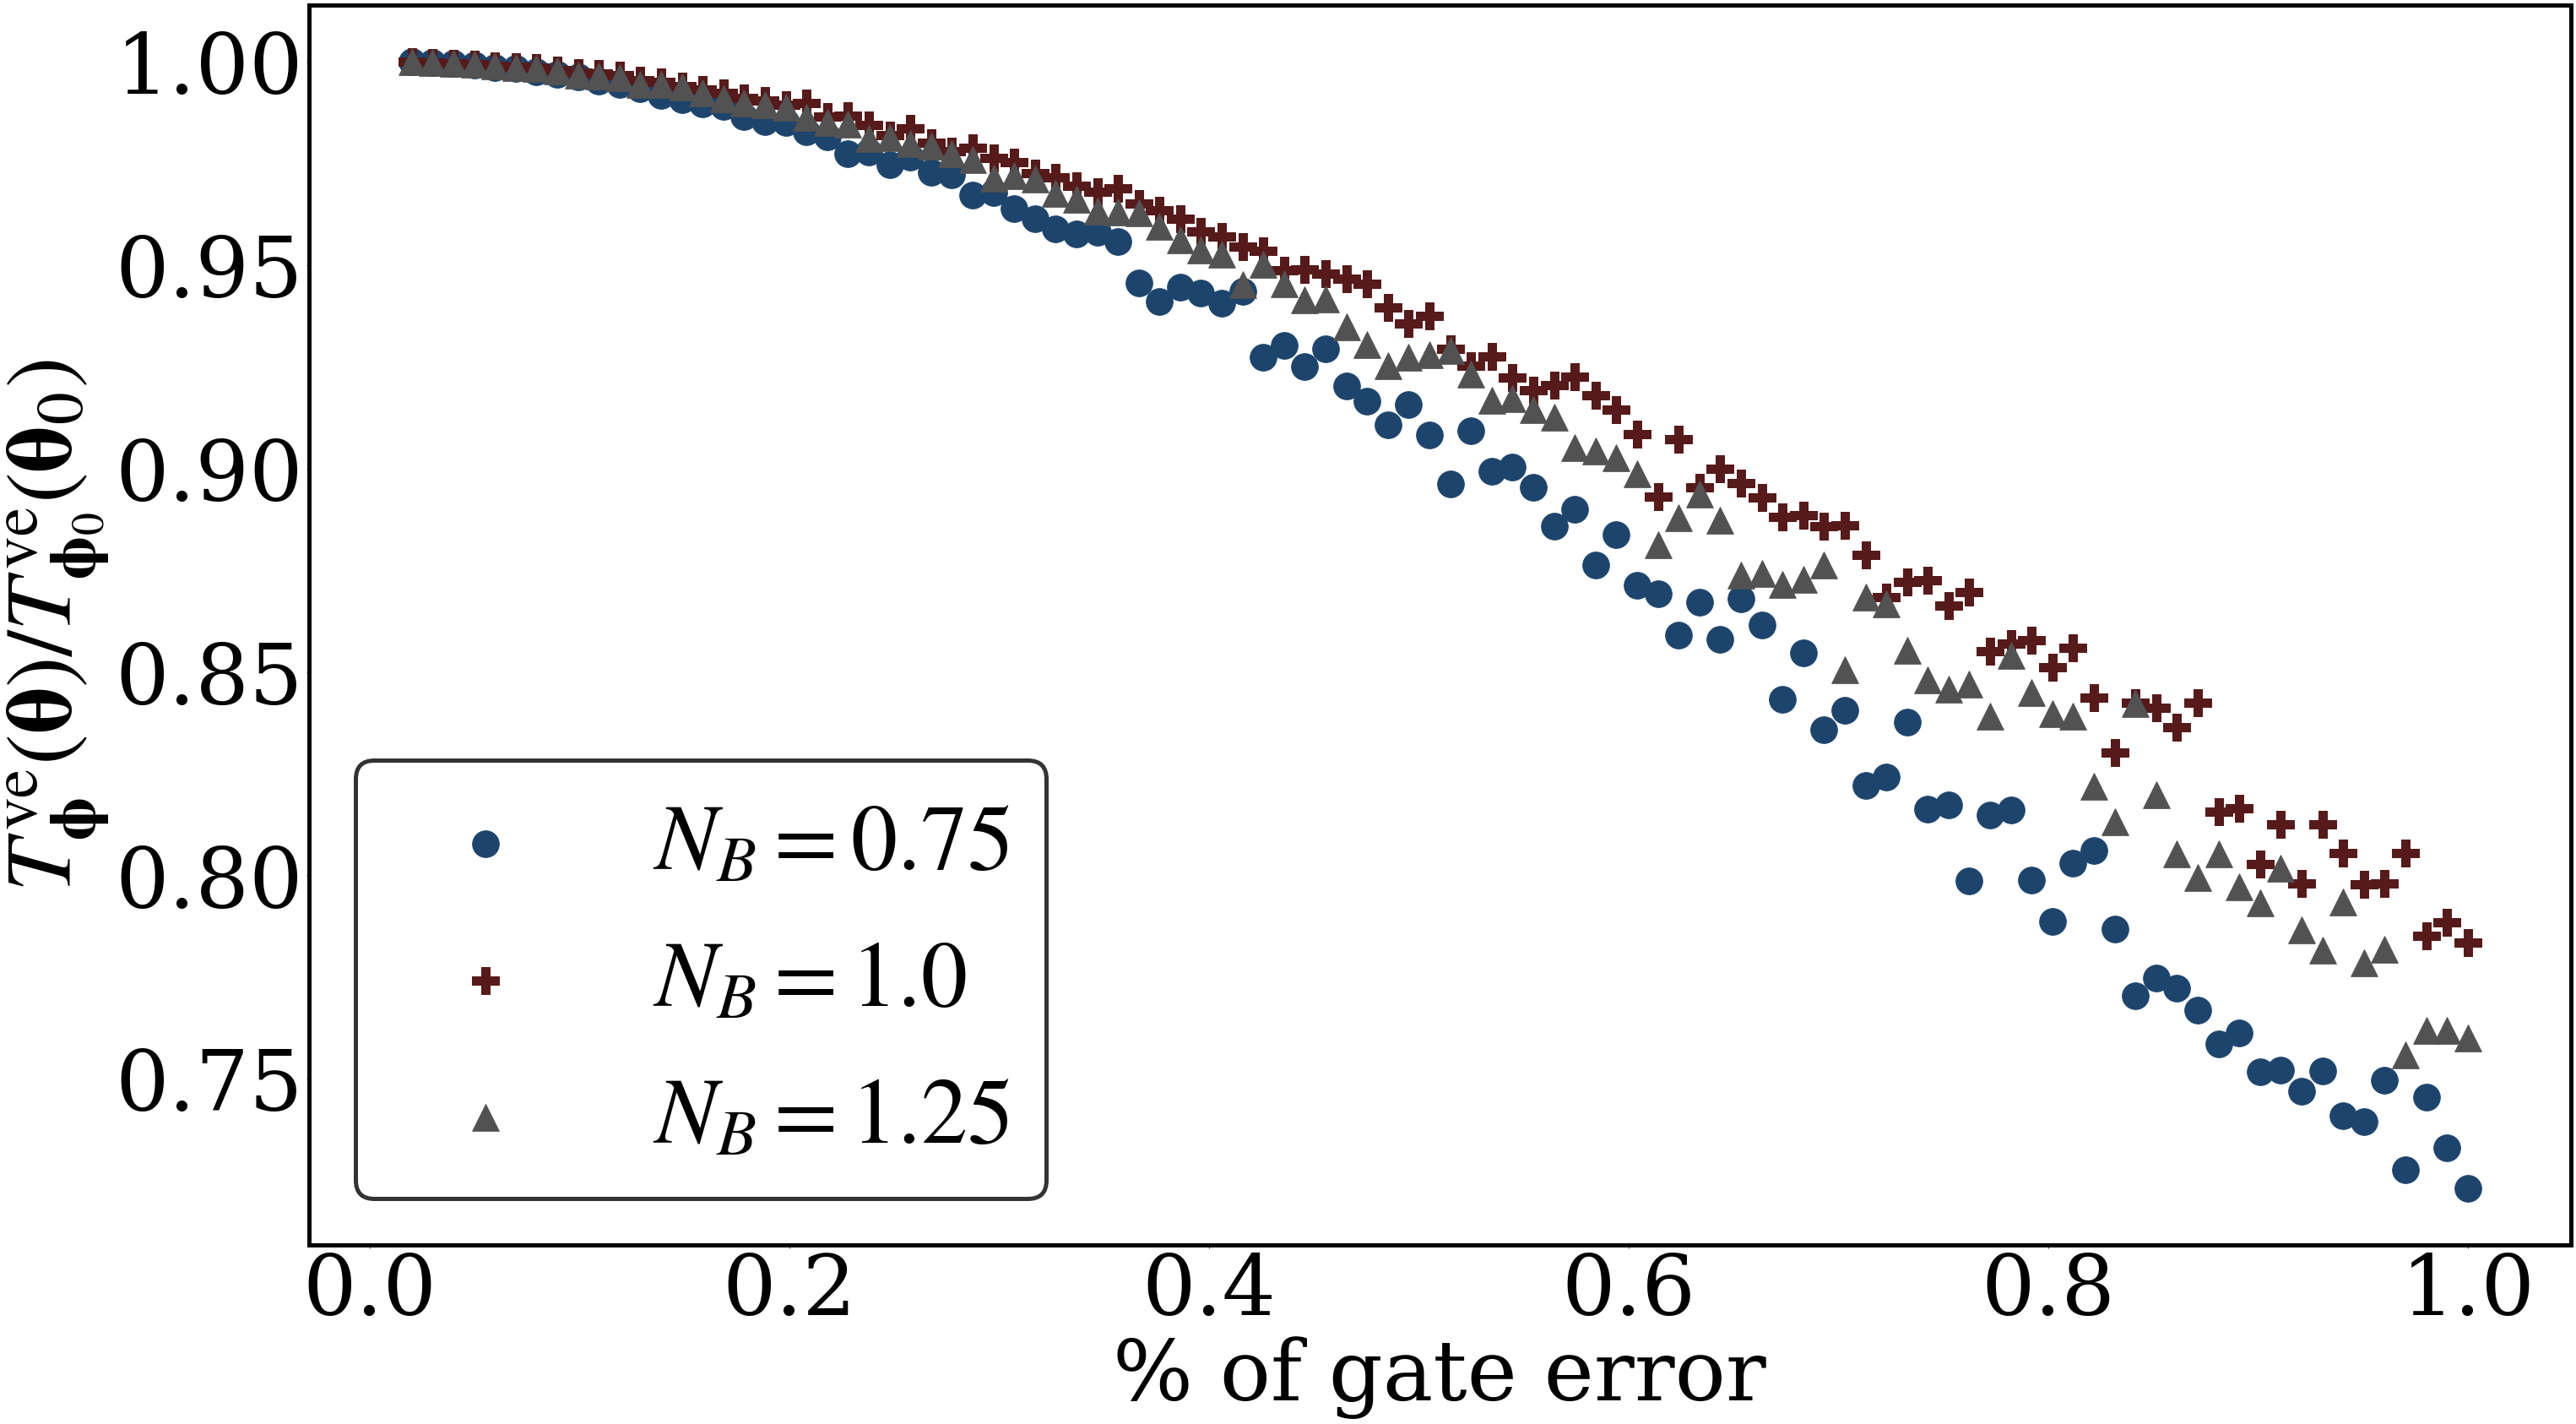

In [15]:
cc = [color1,color3,color5]
m = ["o","P","^"]
plt.rcParams["figure.figsize"] = (48,27)
noise = np.linspace(0.01/50,1e-2,100)
for i in range(len(idx)):
    plt.scatter(100*noise,NoiseAvg[i]/np.amax(NoiseAvg[i]),s=1000,label=r"$N_B = "+str(round(nb[idx[i]],2))+"$",color=cc[i],marker=m[i])#,color=color1)
    #plt.plot(100*noise,NoiseAvg[i]/np.amax(NoiseAvg[i]),color=color5,linestyle="dashed",linewidth=6)
plt.xlabel("% of gate error",fontsize=100)
plt.ylabel(r"$T^{\mathrm{ve}}_{\mathbf{\phi}}(\mathbf{\theta})/T^{\mathrm{ve}}_{\mathbf{\phi}_0}(\mathbf{\theta}_0)$",fontsize=110)
legend = plt.legend(loc=3,fontsize=110)
legend.get_frame().set_linewidth(5)
legend.get_frame().set_edgecolor("black")

In [6]:
round(60 + (150*1096/1572) + (150*1783/2210) + (150*1686/3051)) + 32

400

In [76]:
eta_lin = np.logspace(-6,0-6/100,100)
trace_ratio = np.zeros((100,100),dtype=np.complex128)
chernoff_ratio = np.zeros((100,100),dtype=np.complex128)
bhat_ratio = np.zeros((100,100),dtype=np.complex128)
Vtheta1 = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)[19]

for i in range(len(eta_lin)):
    nb = np.linspace(2/100,2,100)
    print(eta_lin[i])
    for j in range(len(nb)):
        
        obj1 = gauss_vqi(1,1,nb[j],eta_lin[i],0.1,parity=True,load=True,idler_factors = (1,2,))
        obj1.U_theta, obj1.V_theta = Vtheta1
        obj0 = gauss_vqi(1,1,nb[j],eta_lin[i],0.1)
        obj0.U_theta[-2] = np.arcsinh(np.sqrt(0.1))
        
        trace_ratio[i,j] = obj1.trace_distance()/obj0.trace_distance()
        #chernoff_ratio[i,j] = (1-obj1.chernoff())/(1-obj0.chernoff())
        bhat_ratio[i,j] = obj1.bhattacharya()/obj0.bhattacharya()

1e-06
1.1481536214968817e-06
1.3182567385564074e-06
1.5135612484362072e-06
1.7378008287493763e-06
1.9952623149688787e-06
2.2908676527677747e-06
2.6302679918953817e-06
3.0199517204020193e-06
3.467368504525317e-06
3.981071705534969e-06
4.570881896148752e-06
5.248074602497723e-06
6.025595860743581e-06
6.9183097091893625e-06
7.943282347242822e-06
9.120108393559096e-06
1.0471285480508985e-05
1.2022644346174132e-05
1.3803842646028866e-05
1.584893192461114e-05
1.8197008586099827e-05
2.089296130854041e-05
2.39883291901949e-05
2.754228703338169e-05
3.1622776601683795e-05
3.6307805477010174e-05
4.168693834703355e-05
4.7863009232263804e-05
5.495408738576248e-05
6.309573444801929e-05
7.244359600749906e-05
8.317637711026709e-05
9.549925860214369e-05
0.00010964781961431851
0.00012589254117941674
0.0001445439770745928
0.00016595869074375615
0.00019054607179632481
0.0002187761623949554
0.0002511886431509582
0.0002884031503126609
0.0003311311214825911
0.00038018939632056124
0.0004365158322401661
0.0005

In [26]:
obj0._map(eta=0).dm(cutoff=20).shape

(20, 20, 20, 20)

In [69]:
eta_lin1 = np.logspace(-6,0-6/100,100)
trace_ratio1 = np.zeros((100,3),dtype=np.complex128)
chernoff_ratio1 = np.zeros((100,3),dtype=np.complex128)
Vtheta1 = np.load("data/vac_gauss_th_2mode.npy",allow_pickle=True)[19]

for i in range(len(eta_lin)):
    nb = [0.1,0.5,1.0]
    print(eta_lin[i])
    for j in range(len(nb)):
        
        obj1 = gauss_vqi(1,1,nb[j],eta_lin[i],0.1,parity=True,load=True,idler_factors = (1,2,))
        obj1.U_theta, obj1.V_theta = Vtheta1
        obj0 = gauss_vqi(1,1,nb[j],eta_lin[i],0.1)
        obj0.U_theta[-2] = np.arcsinh(np.sqrt(0.1))
        
        trace_ratio1[i,j] = obj1.trace_distance()/obj0.trace_distance()
        chernoff_ratio1[i,j] = np.log(obj1.chernoff())/np.log(obj0.chernoff())

1e-06


D:\Apps\Anaconda\lib\site-packages\scipy\optimize\optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars


1.1481536214968817e-06
1.3182567385564074e-06
1.5135612484362072e-06
1.7378008287493763e-06
1.9952623149688787e-06
2.2908676527677747e-06
2.6302679918953817e-06
3.0199517204020193e-06
3.467368504525317e-06
3.981071705534969e-06
4.570881896148752e-06
5.248074602497723e-06
6.025595860743581e-06
6.9183097091893625e-06
7.943282347242822e-06
9.120108393559096e-06
1.0471285480508985e-05
1.2022644346174132e-05
1.3803842646028866e-05
1.584893192461114e-05
1.8197008586099827e-05
2.089296130854041e-05
2.39883291901949e-05
2.754228703338169e-05
3.1622776601683795e-05
3.6307805477010174e-05
4.168693834703355e-05
4.7863009232263804e-05
5.495408738576248e-05
6.309573444801929e-05
7.244359600749906e-05
8.317637711026709e-05
9.549925860214369e-05
0.00010964781961431851
0.00012589254117941674
0.0001445439770745928
0.00016595869074375615
0.00019054607179632481
0.0002187761623949554
0.0002511886431509582
0.0002884031503126609
0.0003311311214825911
0.00038018939632056124
0.0004365158322401661
0.0005011872

Text(0.5, 1.0, 'Trace distance ratio')

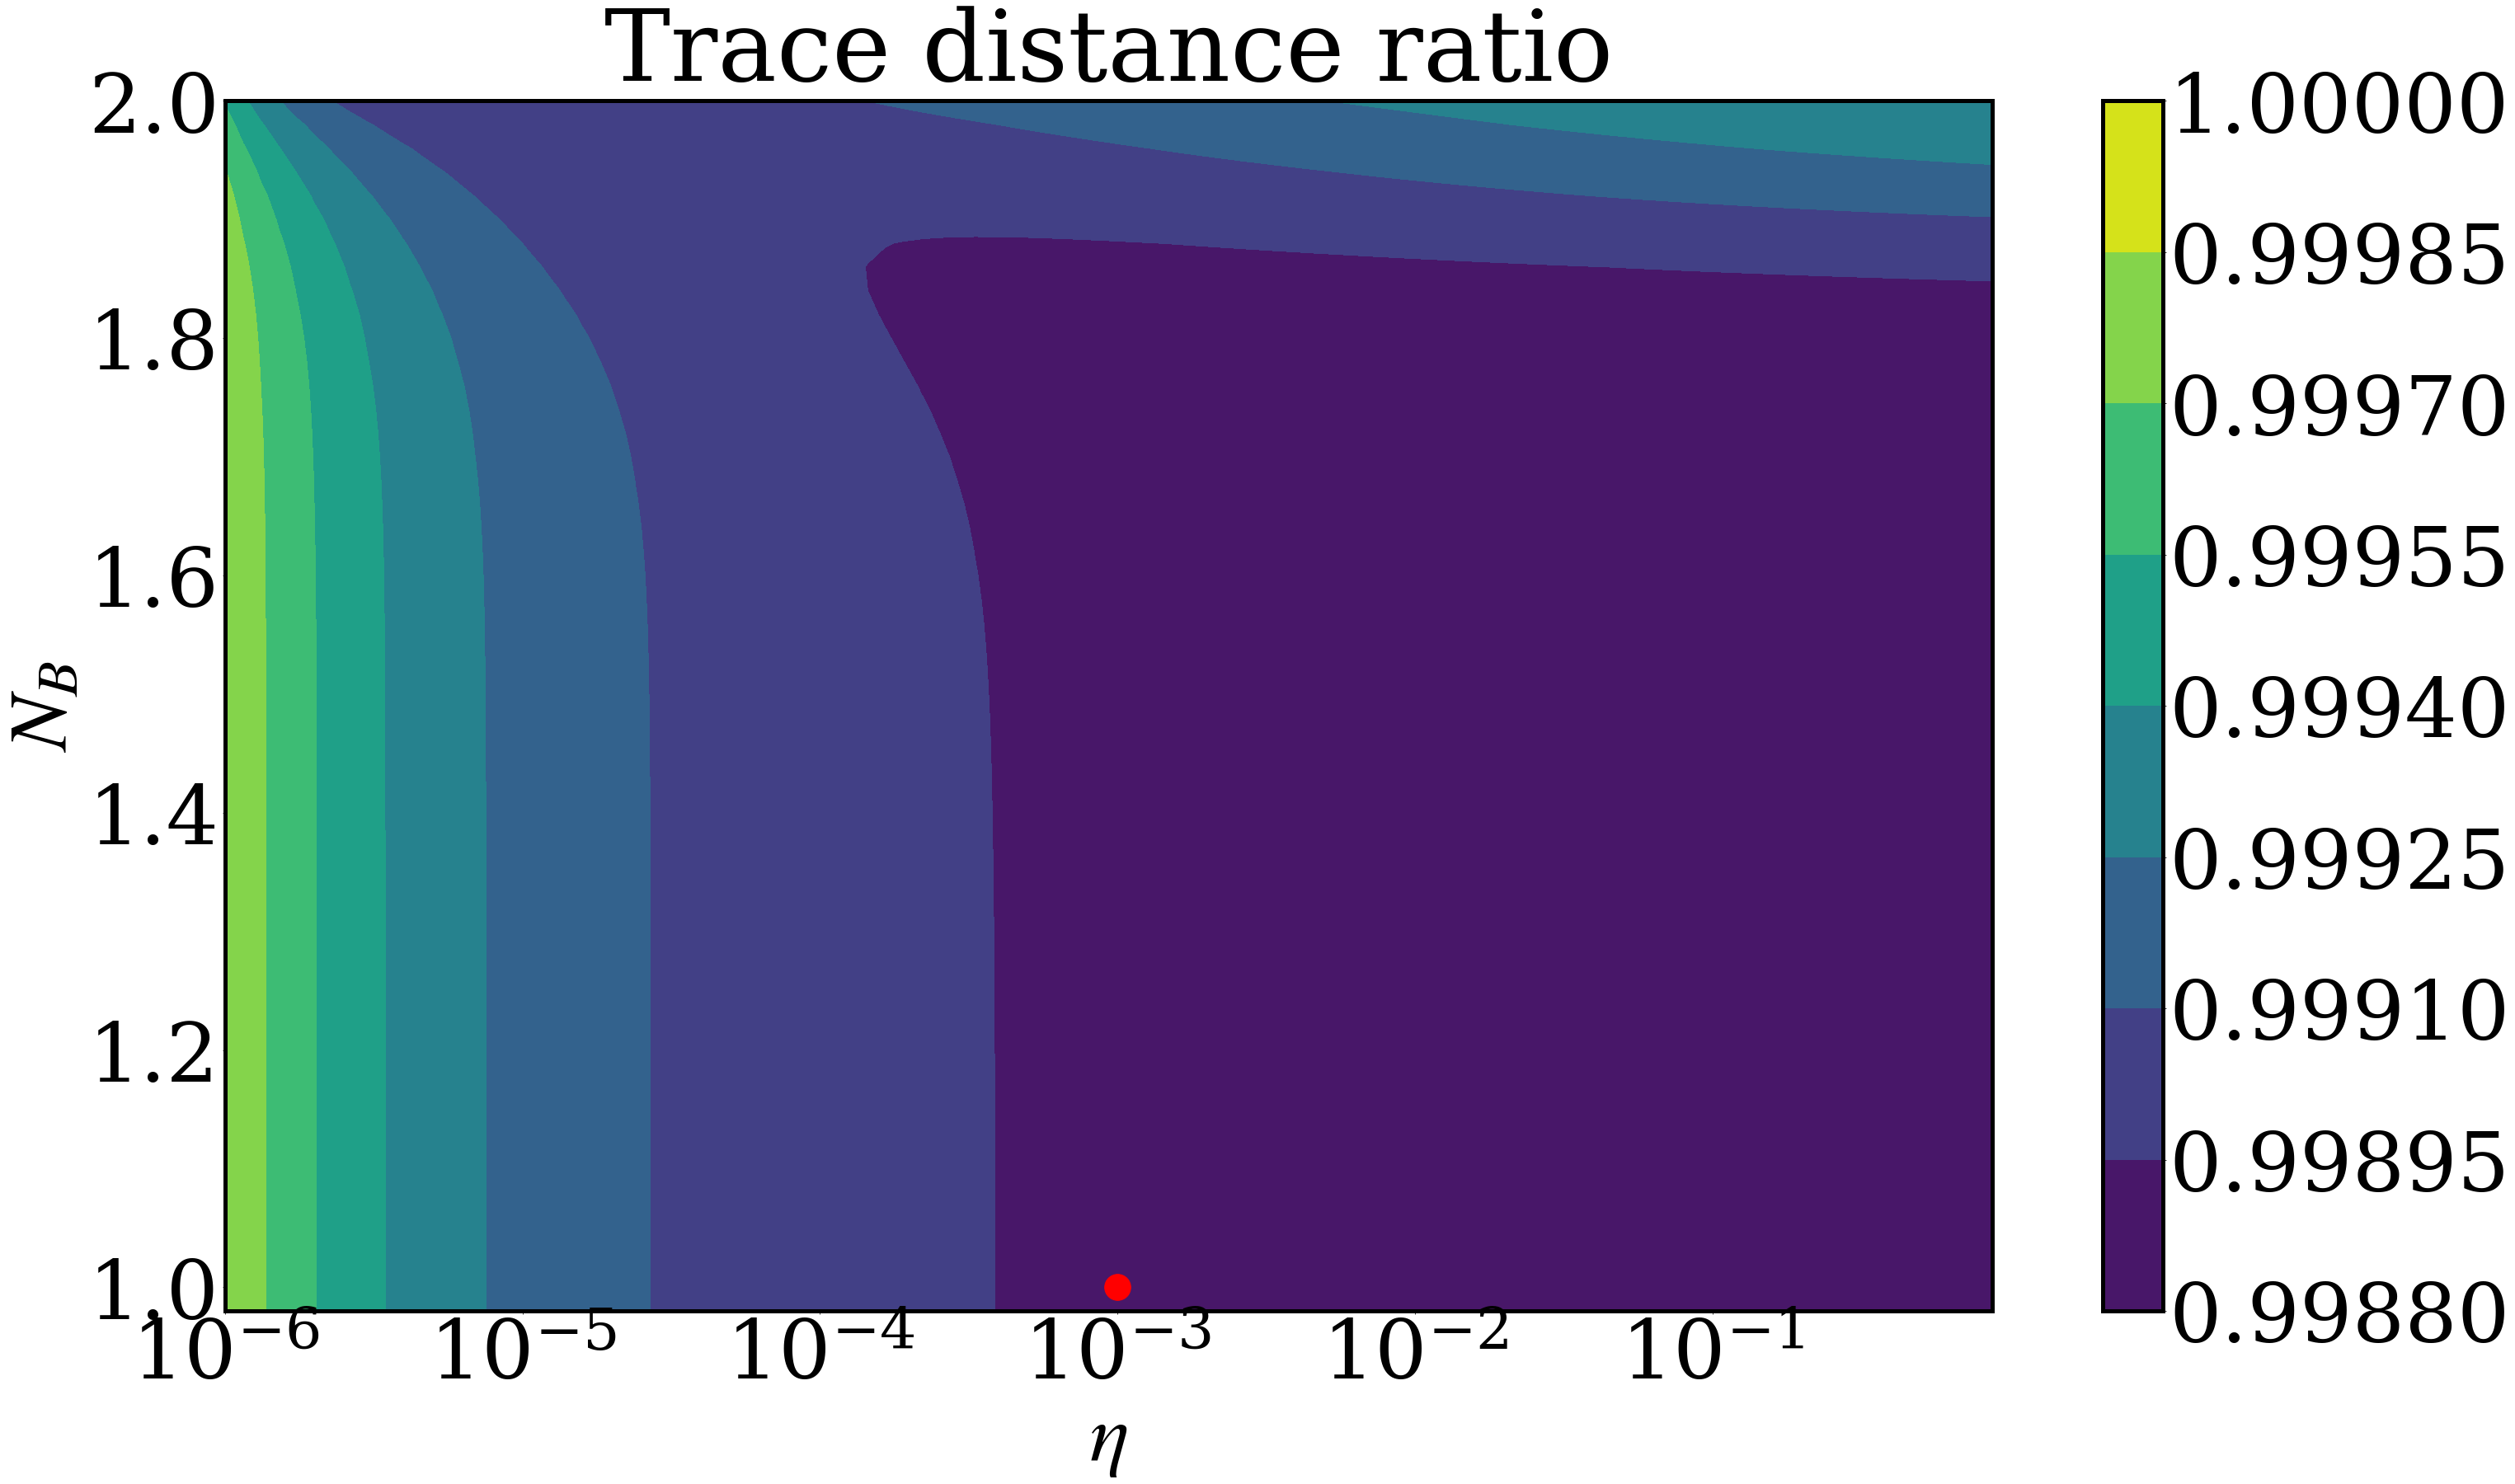

In [116]:
plt.contourf(eta_lin,nb[48:],trace_ratio[48:,:],cmap="viridis")
plt.xscale('log')
plt.colorbar()
plt.scatter(1e-3,1,color='red',s=1000)
plt.xlabel(r"$\eta$")
plt.ylabel(r"$N_B$")
plt.title(r"Trace distance ratio")

Text(0.5, 1.0, 'Chernoff bound ratio')

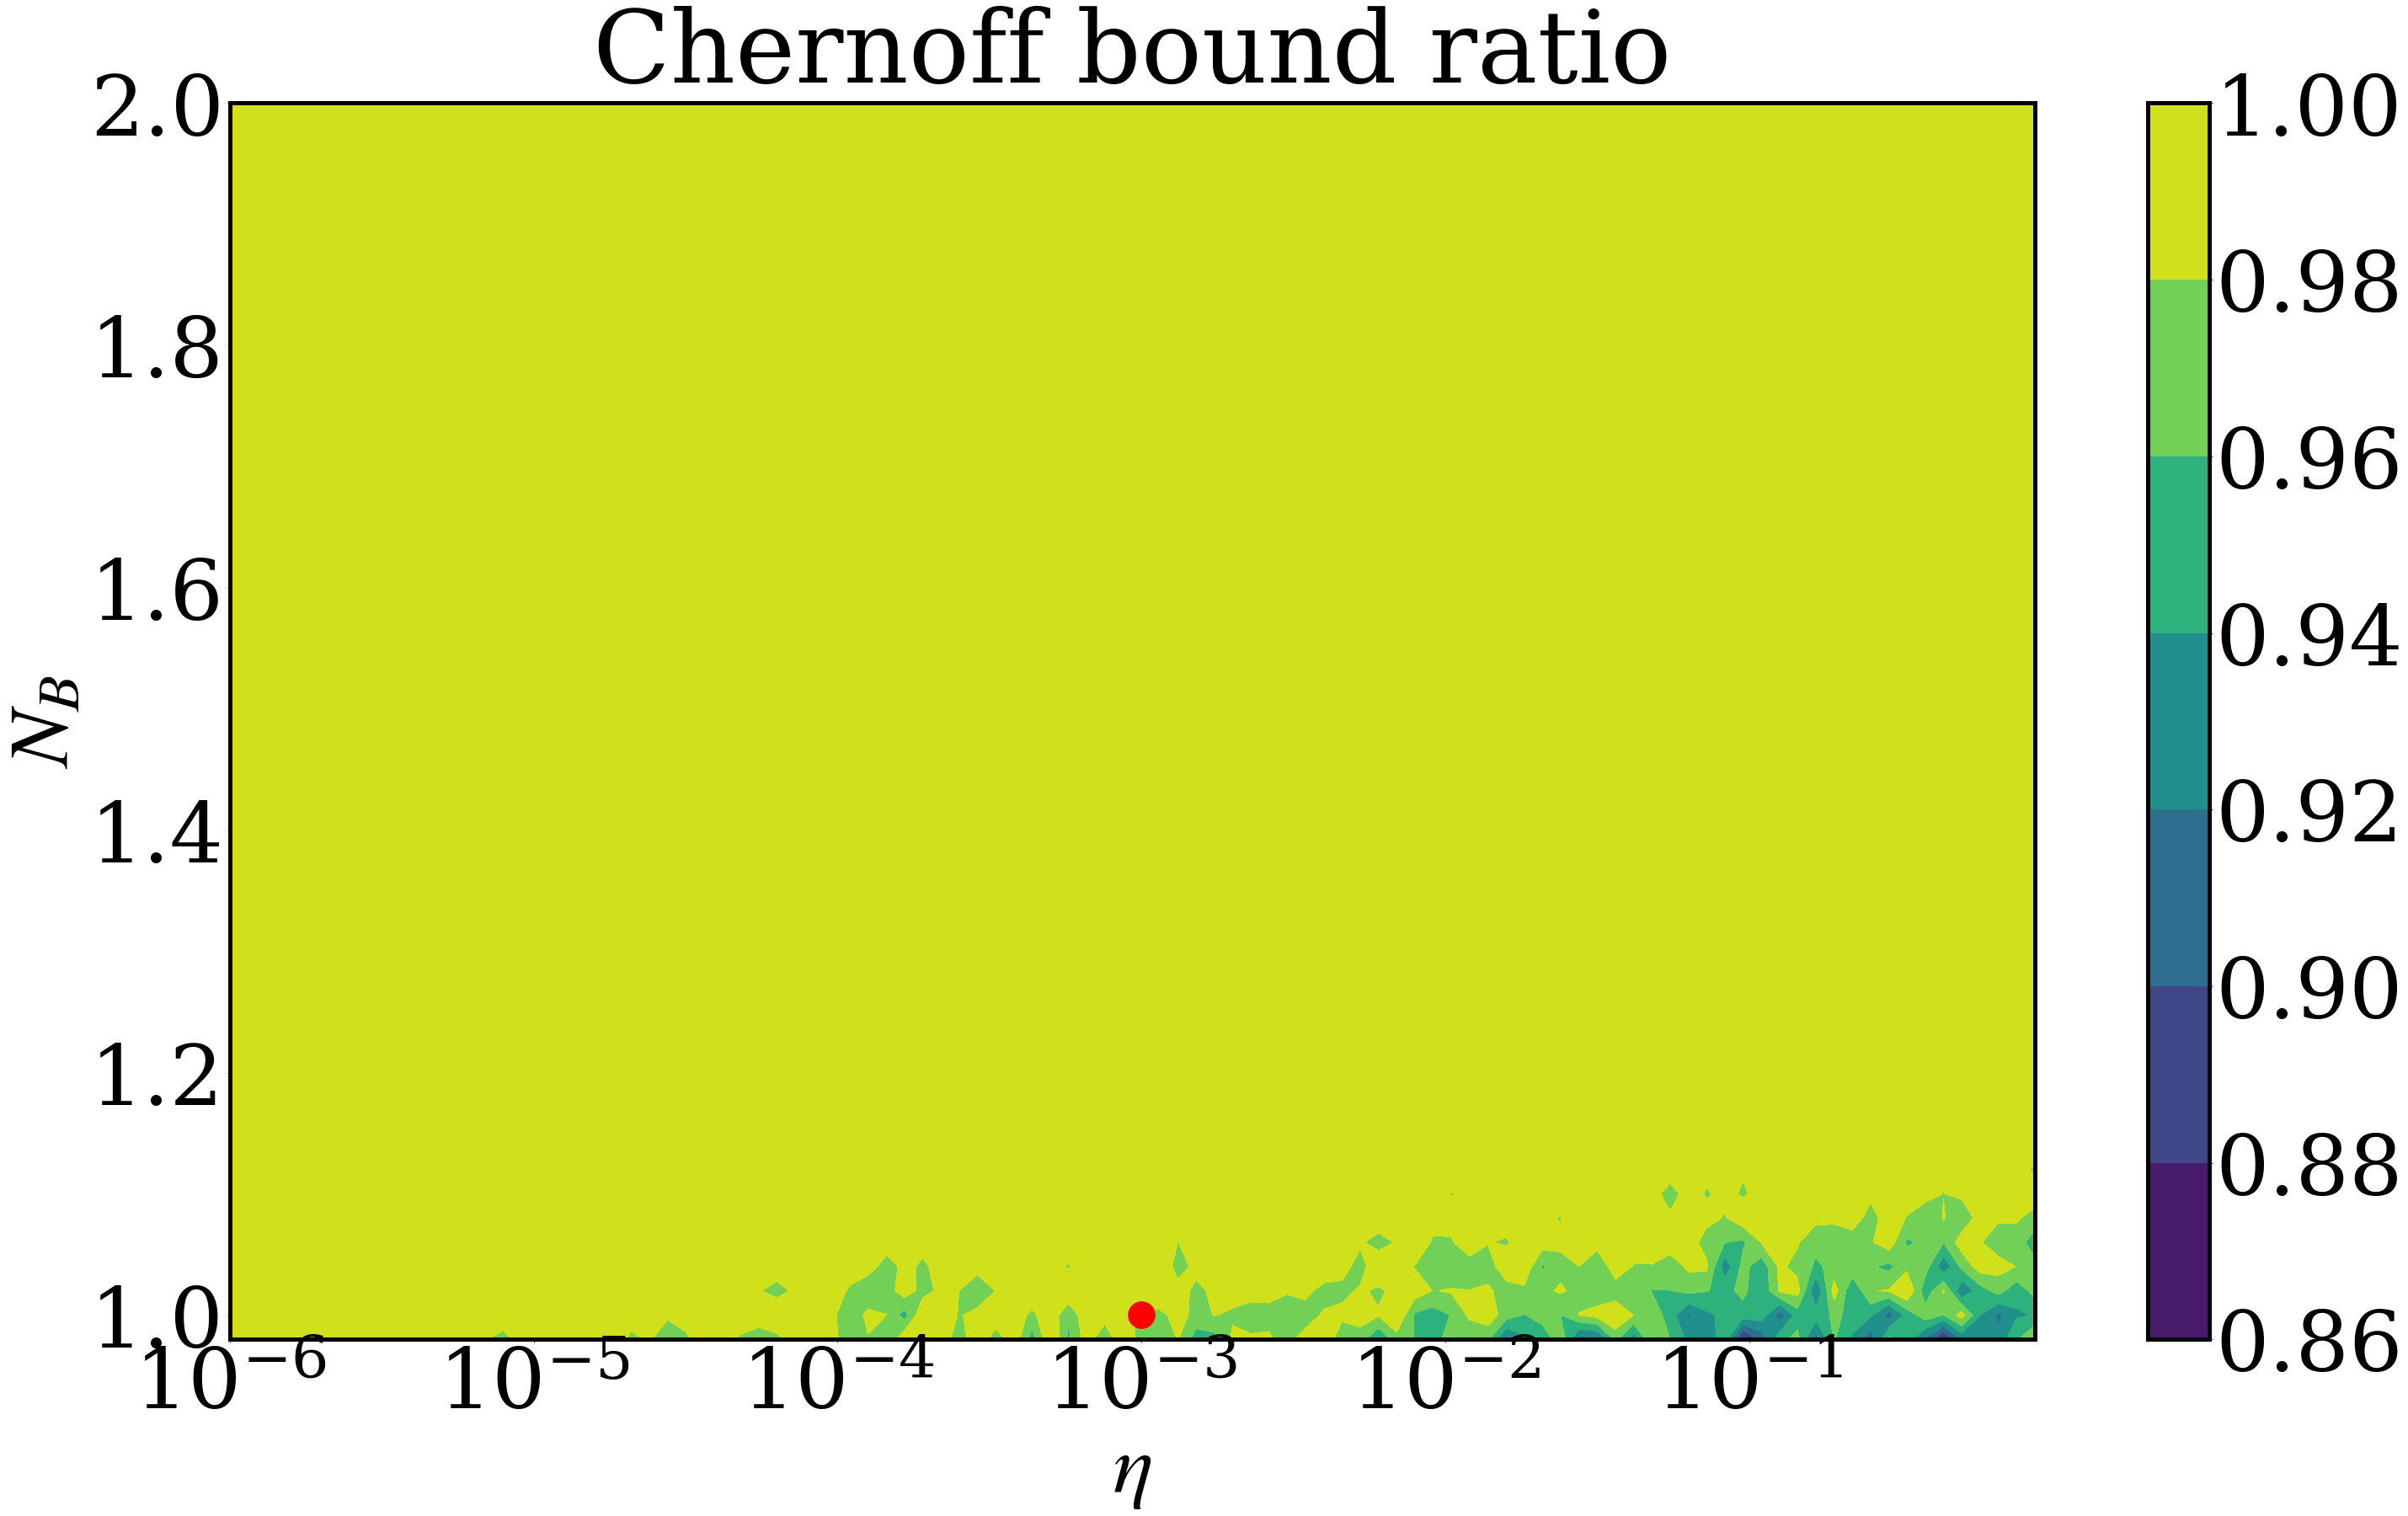

In [117]:
plt.contourf(eta_lin,nb[48:],np.minimum(bhat_ratio[48:,:],bhat_ratio[48:,:]/bhat_ratio[48:,:]),cmap="viridis")
plt.xscale('log')
plt.colorbar()#ticks=[0.90,0.92,0.94,0.96,0.98,1.0])
plt.scatter(1e-3,1,color='red',s=1000)

plt.xlabel(r"$\eta$")
plt.ylabel(r"$N_B$")
plt.title(r"Chernoff bound ratio")

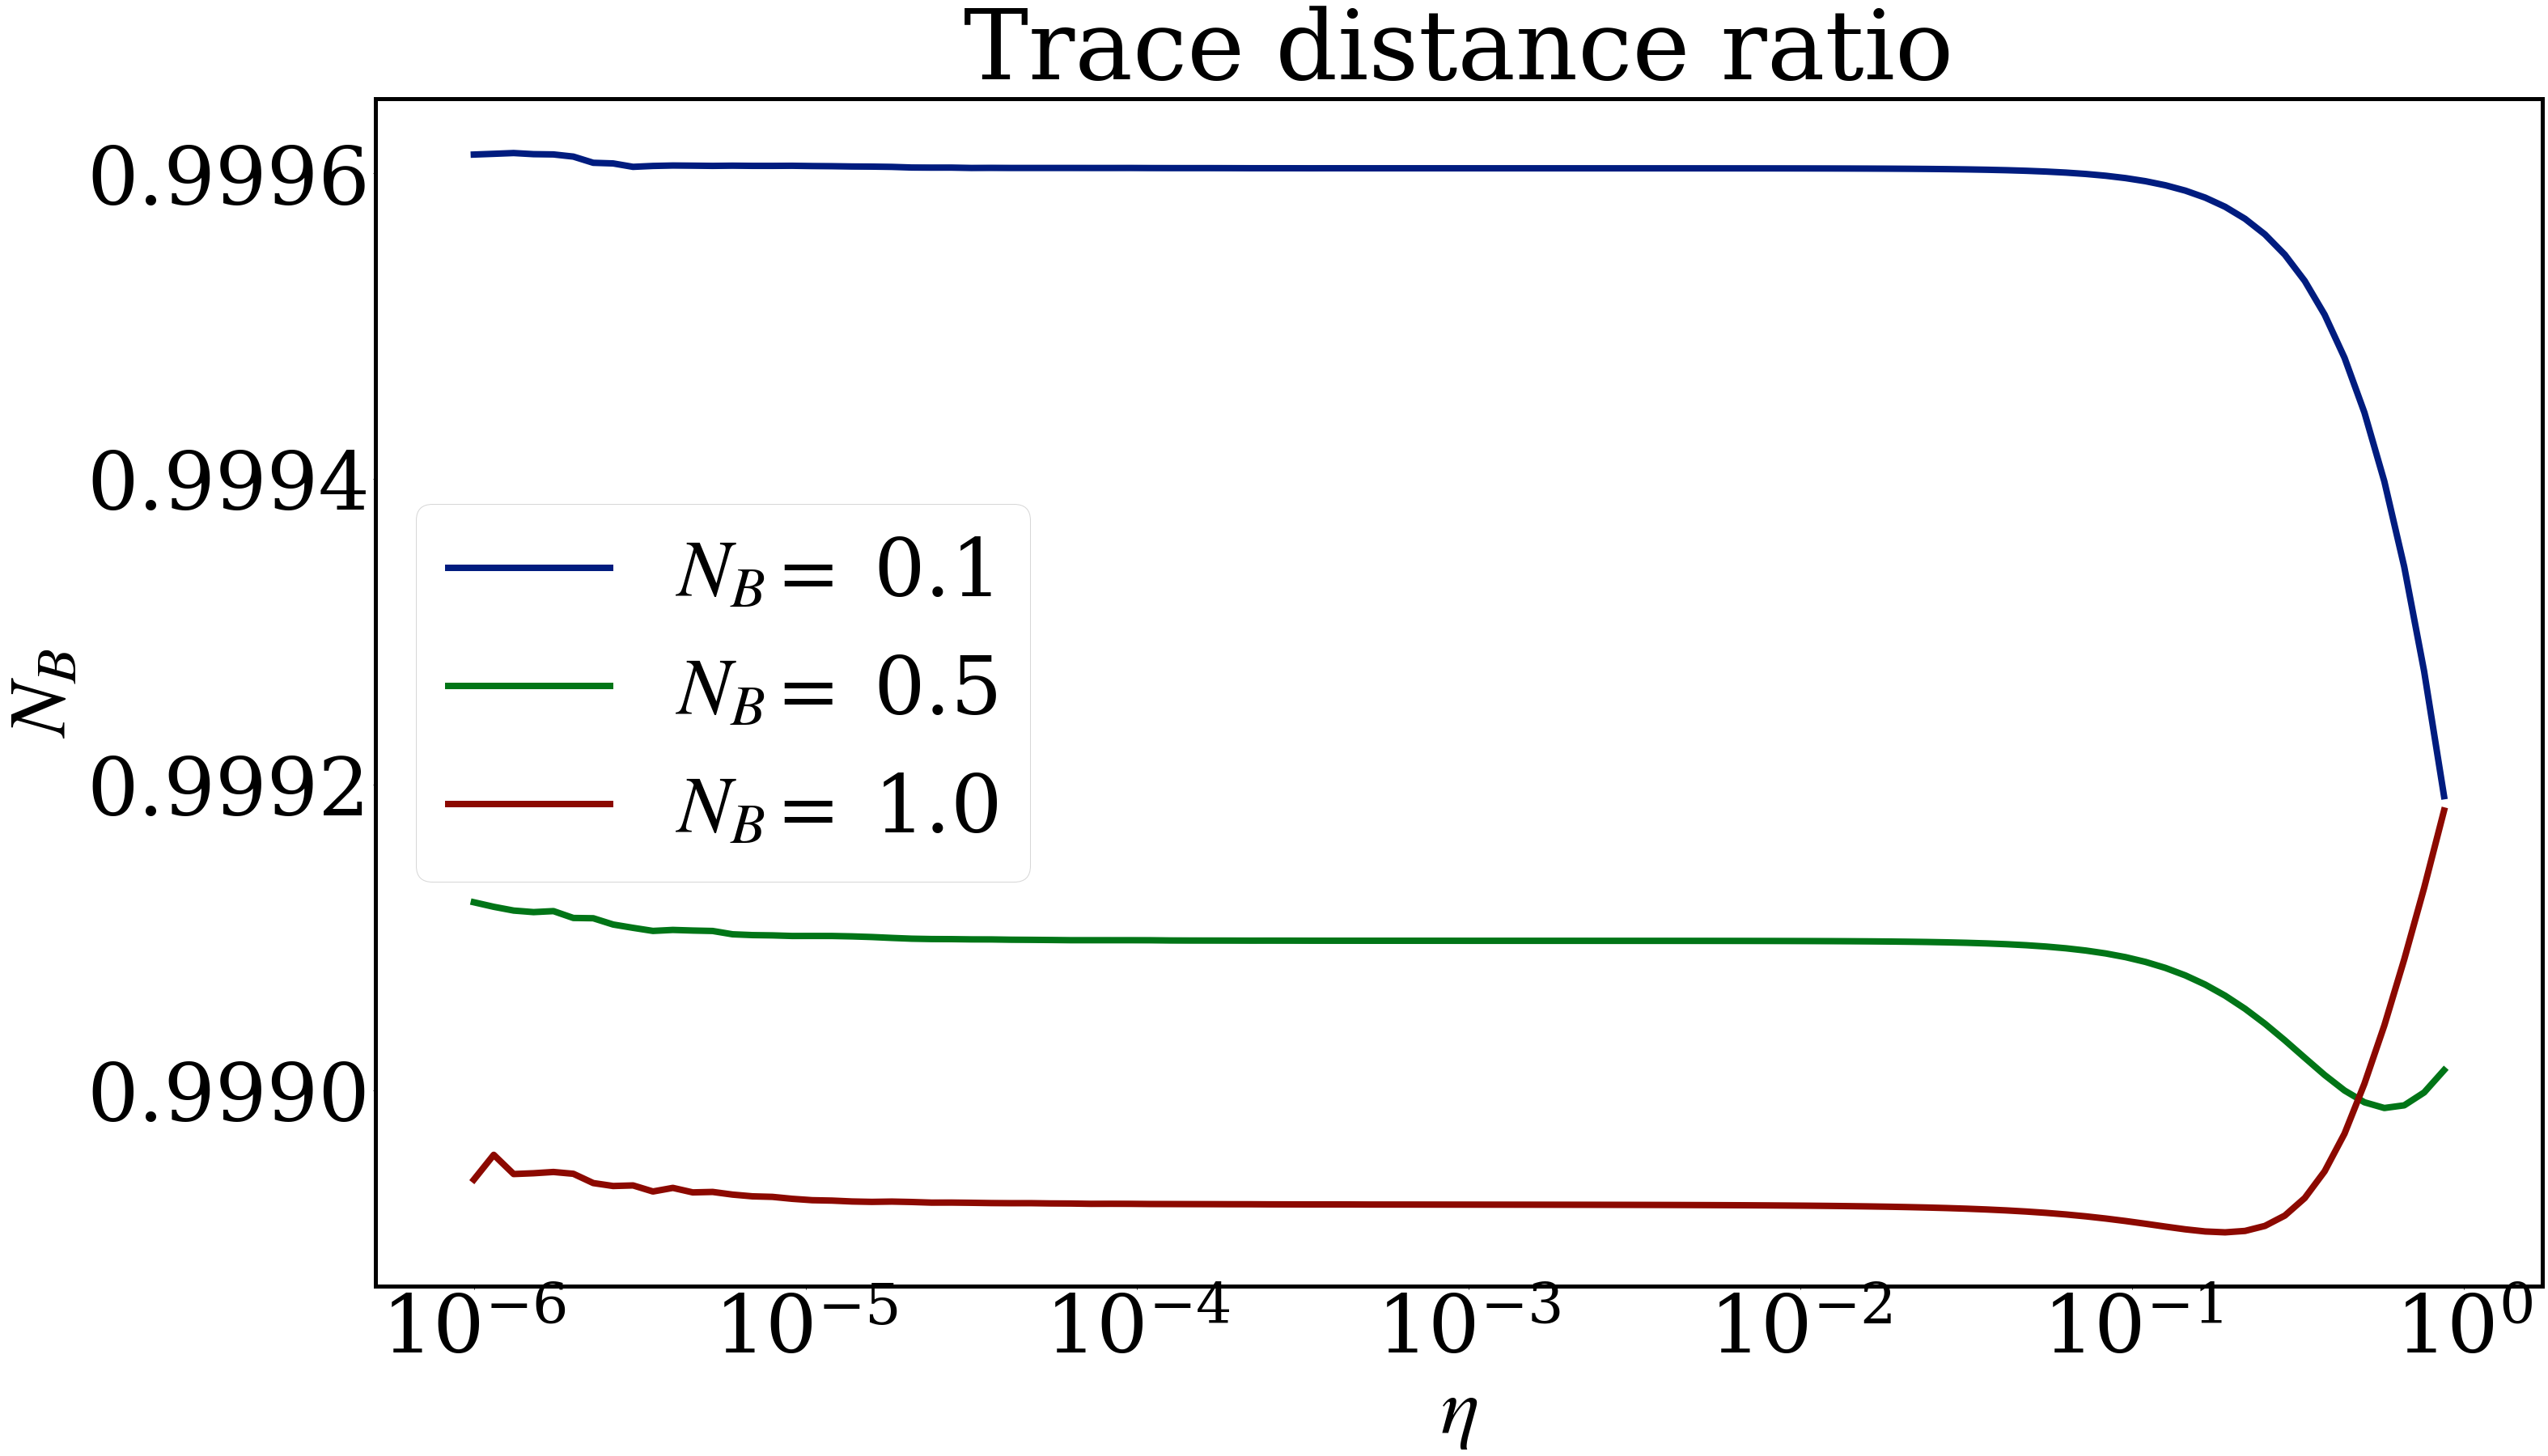

In [74]:
for j in range(len(nb)):
    plt.plot(eta_lin,np.abs(trace_ratio1[:,j]),label=r"$N_B =$ "+str(nb[j]),linewidth=8)
plt.xscale('log')
plt.xlabel(r"$\eta$")
plt.ylabel(r"$N_B$")
plt.title(r"Trace distance ratio")
plt.legend()

Text(0.5, 1.0, 'Chernoff bound ratio')

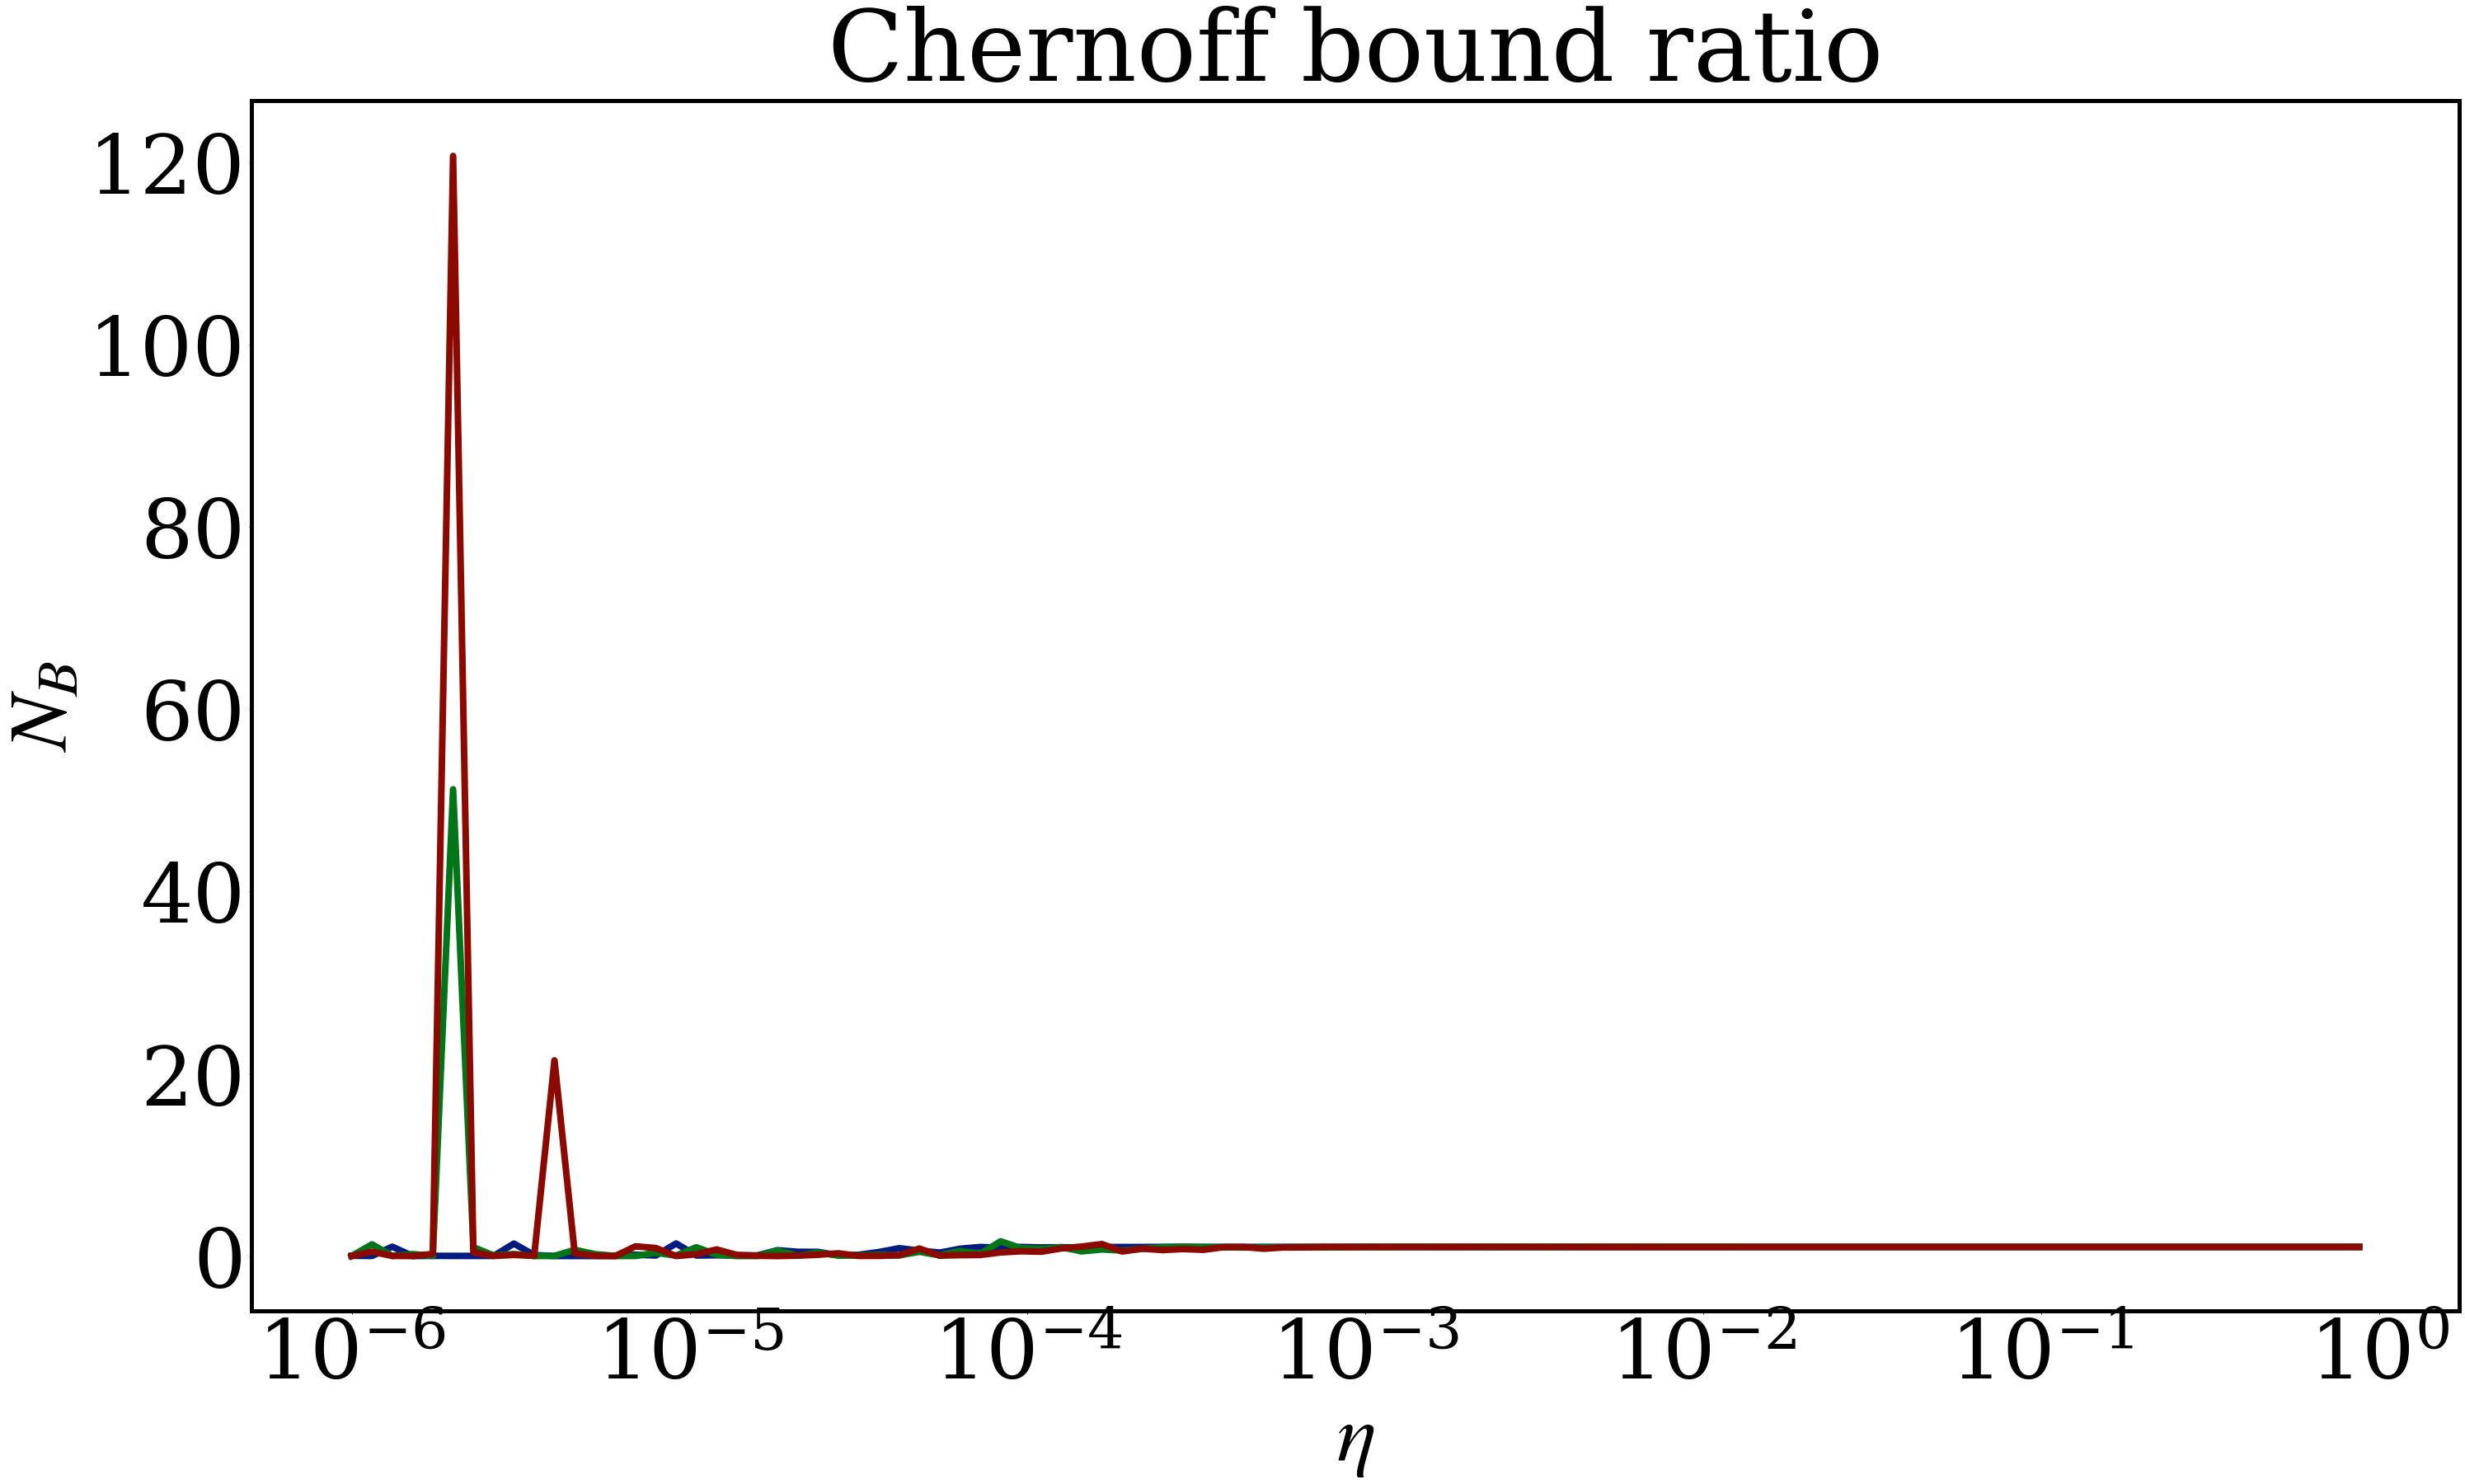

In [71]:
for j in range(len(nb)):
    plt.plot(eta_lin,np.abs(chernoff_ratio1[:,j]),label=r"$N_B =$ "+str(nb[j]),linewidth=8)
plt.xscale('log')
plt.xlabel(r"$\eta$")
plt.ylabel(r"$N_B$")
plt.title(r"Chernoff bound ratio")

Text(0.5, 1.0, 'Chernoff bound ratio')

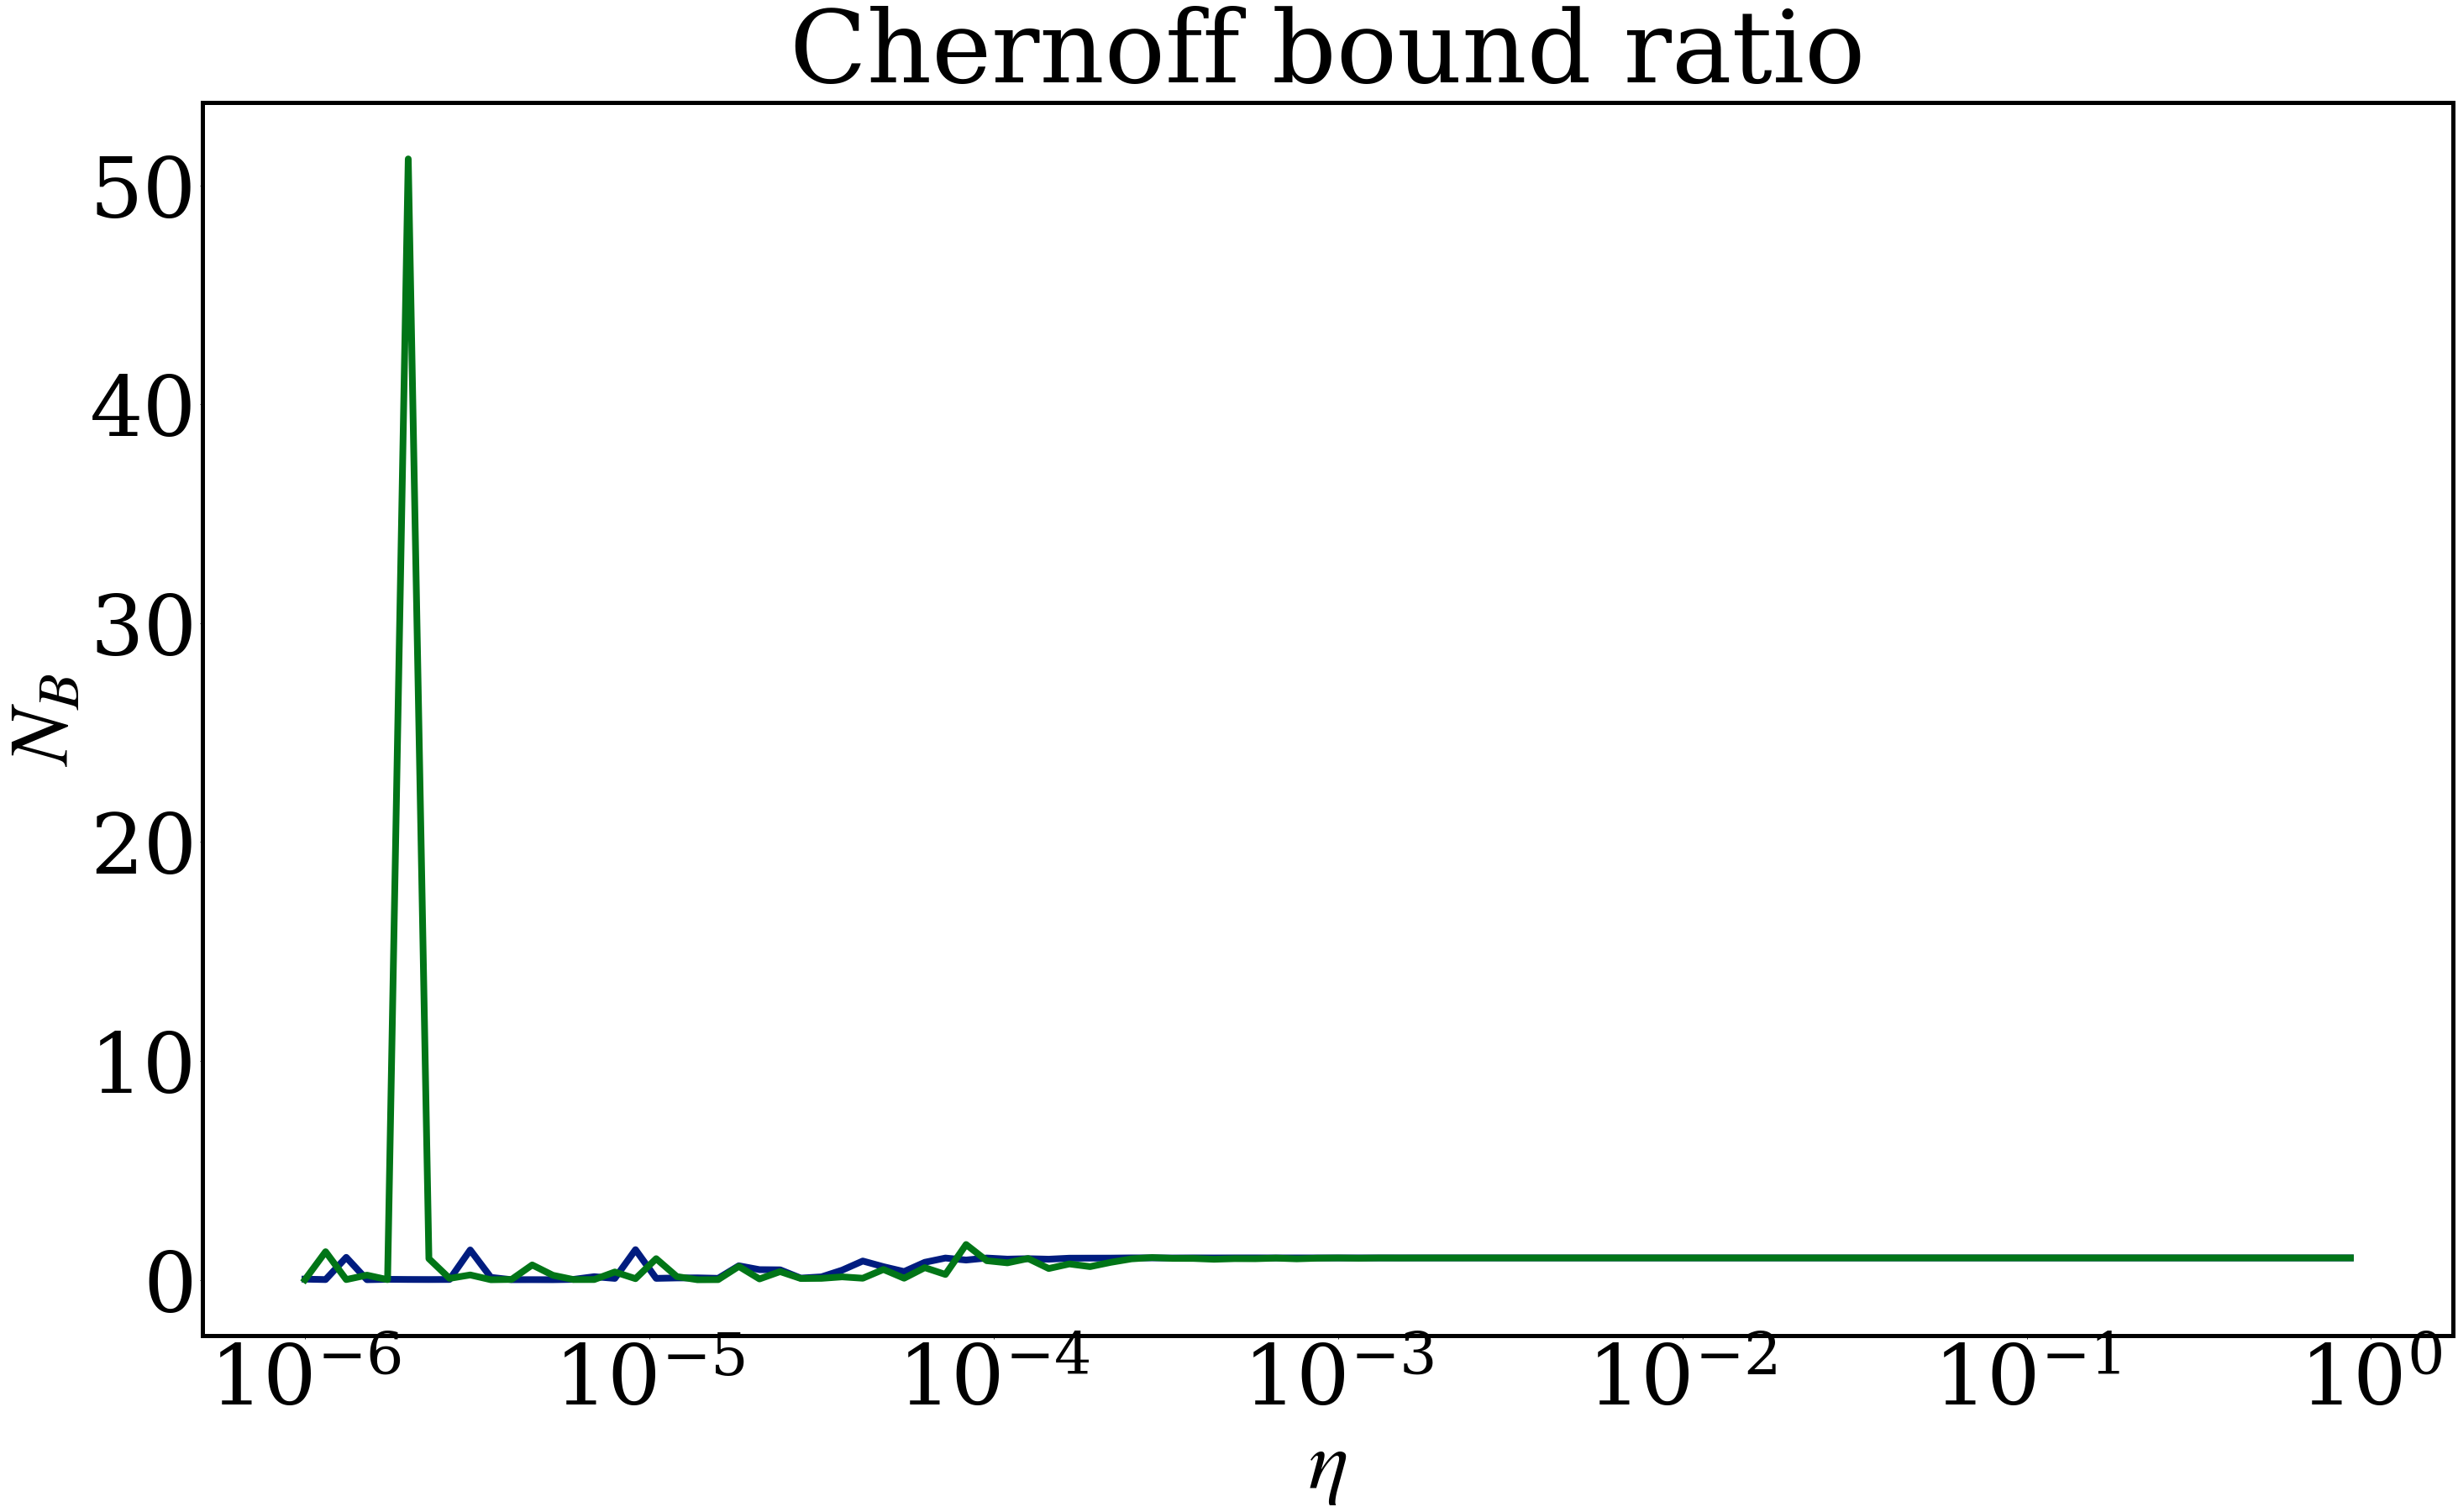

In [73]:
for j in range(2):
    plt.plot(eta_lin,np.abs(chernoff_ratio1[:,j]),label=r"$N_B =$ "+str(nb[j]),linewidth=8)
plt.xscale('log')
plt.xlabel(r"$\eta$")
plt.ylabel(r"$N_B$")
plt.title(r"Chernoff bound ratio")

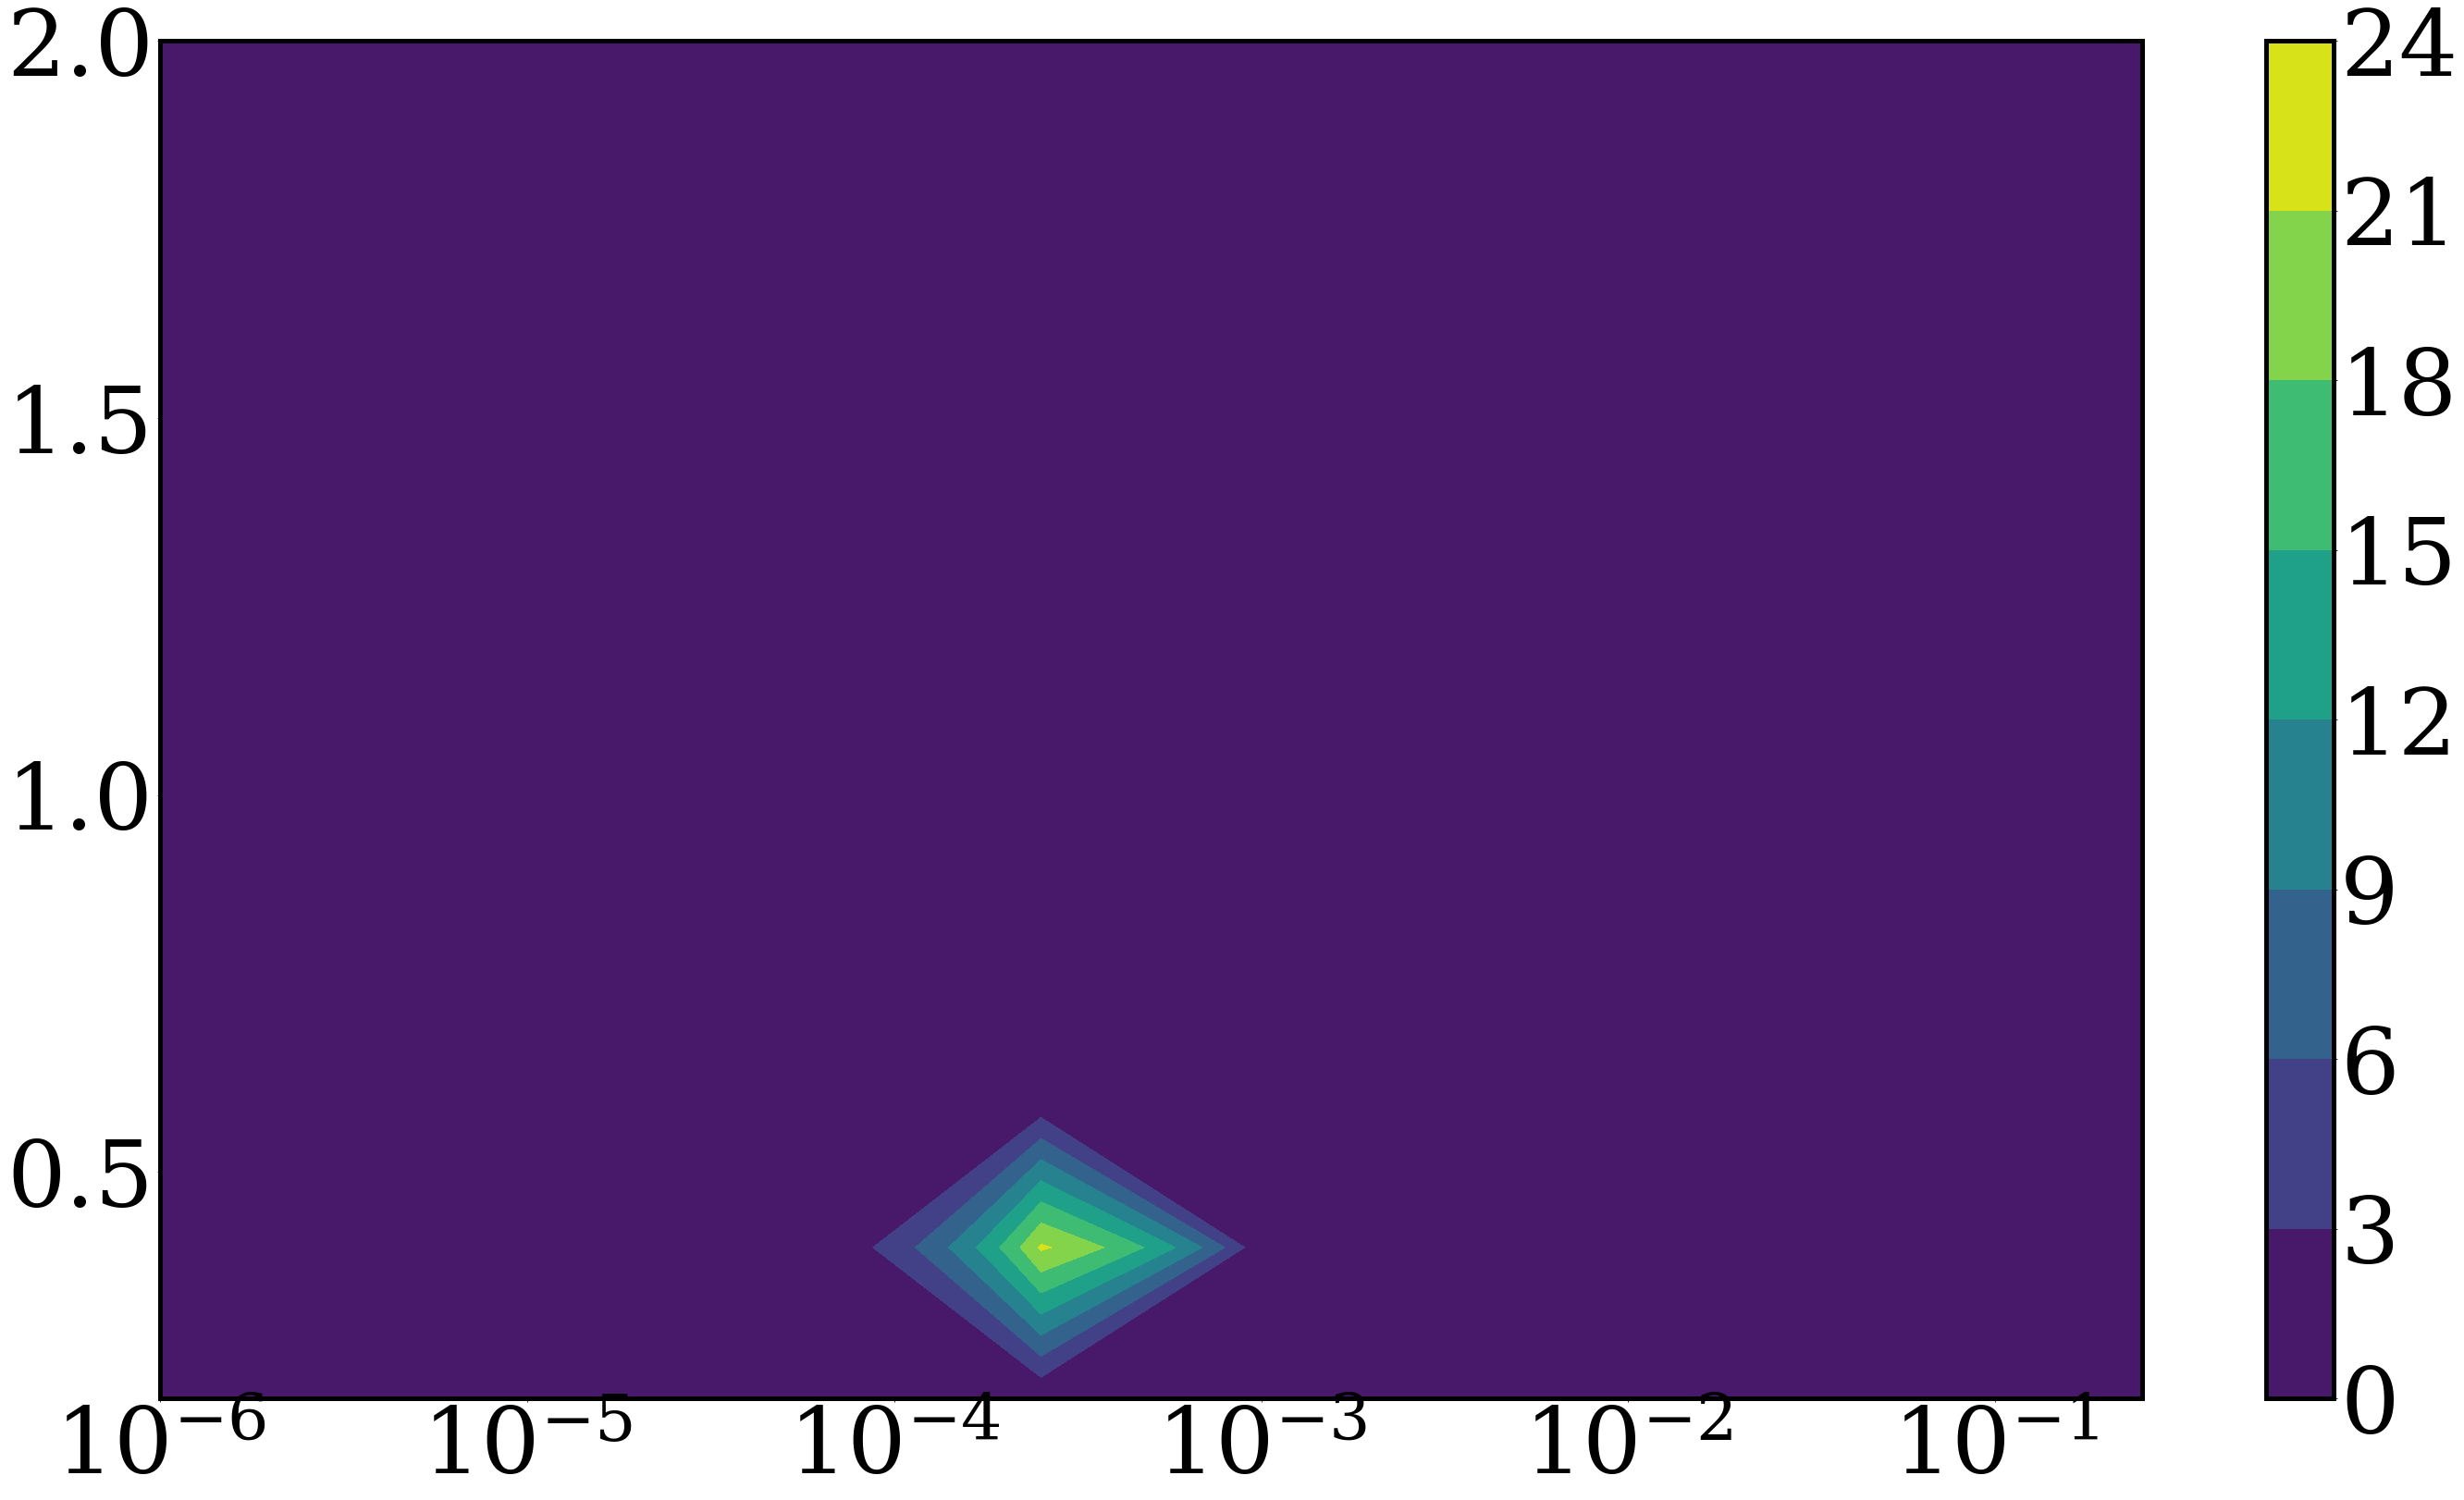

In [50]:
plt.contourf(eta_lin,nb,(chernoff_ratio))
plt.xscale('log')
plt.colorbar()
